In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys, os, glob
from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.table import Column, Table, vstack, join, unique
from astroquery.vizier import Vizier
from astroquery.ipac.irsa import Irsa
Vizier.TIMEOUT = 3600
Vizier.clear_cache()
from importlib import reload
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from itertools import product
from astropy.units import equivalencies

# access utilities provided in cigale package
sys.path.append('../../SED/manual/code')
import convert_Fx
import xray_filter

# 3395038617

In [134]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

# original code

In [2]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [3]:
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read DES AGN table and get the photometry

In [ ]:
import pandas as pd
df_phot_gal_all = pd.read_csv('des/df_phot_gal_all.csv')

In [ ]:
# Read final DES candidates
data_agn = ascii.read('des_agn_updated.txt')
cat_agn = SkyCoord(data_agn['RA'], data_agn['dec'], unit='deg')

# Match photometry to final DES candidates
coord_phot_gal = SkyCoord(df_phot_gal_all['RA'], df_phot_gal_all['DEC'], unit=u.deg)
idx_phot,idx_des,d2d,d3d = cat_agn.search_around_sky(coord_phot_gal, 1*u.arcsec)

df_phot_gal_all_var = df_phot_gal_all.iloc[idx_phot]
df_phot_gal_all_var

### CIGALE

In [361]:
cigale_dir = 'cigale'

central_wavelengths = np.array([0.354, 0.475, 0.622, 0.763, 0.905, 1.25, 1.65, 2.20])*u.um
band_keys = ['U', 'G', 'R', 'I', 'Z', 'J', 'H', 'KS']

# Save photometry data
fmt = ' '.join(['%d'] + ['%0.6f']*(len(band_keys)*2 + 1)) # 17
hdr = 'id redshift u_prime g_prime r_prime i_prime z_prime vista.vircam.J vista.vircam.H vista.vircam.Ks u_prime_err g_prime_err r_prime_err i_prime_err z_prime_err vista.vircam.J_err vista.vircam.H_err vista.vircam.Ks_err'
print(len(hdr.split()))

data_phot = np.full([len(df_phot_gal_all_var), len(hdr.split(' '))], -9999.)
for i,b in enumerate(band_keys):
    flux = (df_phot_gal_all_var['MAG_' + b].values*u.ABmag).to(u.mJy).value
    mag_err = (df_phot_gal_all_var['MAGERR_' + b]).values
    #mag_err = np.sqrt(mag_err**2 + rms**2)
    # dmag = 2.5 / ln(10) * dF / F
    # dF = F dmag ln(10) / 2.5
    flux_err = np.log(10)/2.5*flux*mag_err
    
    data_phot[:,2+i] = flux
    data_phot[:,len(band_keys)+2+i] = flux_err

# Index
data_phot[:,0] = np.arange(len(df_phot_gal_all_var))

# Add redshift
mask_specz = np.isfinite(data_agn[r'$z_{\rm{sp}}$'].data)
data_phot[mask_specz,1] = data_agn[r'$z_{\rm{sp}}$'][mask_specz]

z_ph = data_agn[r'$z_{\rm{ph}}$'].data
z_ph = np.array([d[1:4] for d in z_ph], dtype=float)
data_phot[~mask_specz,1] = z_ph[~mask_specz]

np.savetxt('des/cigale/float/phot.dat', data_phot, header=hdr, fmt=fmt)
np.savetxt('des/cigale/fagn0/phot.dat', data_phot, header=hdr, fmt=fmt)
np.savetxt('des/cigale/fagn1/phot.dat', data_phot, header=hdr, fmt=fmt)

18


In [362]:
table.Table(data_phot, names=hdr.split(' '))

id,redshift,u_prime,g_prime,r_prime,i_prime,z_prime,vista.vircam.J,vista.vircam.H,vista.vircam.Ks,u_prime_err,g_prime_err,r_prime_err,i_prime_err,z_prime_err,vista.vircam.J_err,vista.vircam.H_err,vista.vircam.Ks_err
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,1.0,0.003259392833689053,0.005355849305528978,0.009485941101669684,0.01696780209195836,0.02304188250055944,0.03745848042053805,0.04972650083722634,0.06963527779888559,8.536874355701907e-05,3.3975430648396554e-05,5.119057490594685e-05,8.854521412946378e-05,0.0001386066445437506,7.498868198266016e-05,0.00010325624704843901,0.00015643115034388318
1.0,0.2,0.0008034623749175177,0.0013166155749859707,0.002173930597212546,0.003153339361525384,0.005010806091343175,0.00599908408286837,0.009722005749254858,0.01931687680820154,7.254710818976549e-05,1.637347317721991e-05,2.1838771558864996e-05,3.5604513539019204e-05,6.471785975396711e-05,0.0001828123767514316,0.00025934273291877675,0.0002971974174255415
2.0,1.0,0.0013735499393547194,0.0016415889560509927,0.0015992580749092287,0.0024373291243802637,0.0021081955214840207,0.004676741550951573,0.006328821990407733,0.00792965673378994,4.8563449724989015e-05,1.6364115033971475e-05,2.2873763822497293e-05,3.708525631021651e-05,6.961694344607743e-05,4.357361292595105e-05,6.163356022300745e-05,8.007142353039103e-05
3.0,1.3,0.0030643827776379675,0.002151373587160526,0.002755592841046999,0.0026506235807830067,0.0032892094193264915,0.004412015823716417,0.006547080721671842,0.005536421596899963,5.151780922102878e-05,1.714718880179903e-05,2.3326532252469058e-05,3.5532892685995556e-05,6.170472697564273e-05,0.00013204150430538785,0.00022182305516675735,0.0003207749336436598
4.0,0.6,0.008511903167368691,0.00967236554135058,0.012325052780103922,0.012463938682754748,0.013994297767709107,0.00700322875384395,0.006410738382387595,0.008625747725899184,7.267252053802783e-05,2.0220162272586325e-05,2.7111241620652663e-05,4.232192744177975e-05,7.400395246668162e-05,0.00017026563420514067,0.000226827058713145,0.0002766813533326393
5.0,0.803,0.0008164933492307221,0.0011504784367894166,0.0016431083598161913,0.0030481442360198586,0.0034146230006585824,0.002464831720798562,0.0035848720720882306,0.0074207149543490366,5.353806155401492e-05,1.5452440232882362e-05,2.092514952161251e-05,3.719925478919871e-05,6.102366829836989e-05,9.677074166069276e-05,0.00011816955877905482,0.0002498116295609276
6.0,1.2,0.06497441236313248,0.07427176231191354,0.0766340403243844,0.07320712510726568,0.07561773570085539,0.1295867439500251,0.11339653341204758,0.17092878011475648,0.00028523090862848065,9.81054013174942e-05,0.00012506049168445438,0.00018755643780091988,0.00032127529061776194,0.0018015171970248624,0.001862178613142762,0.0023765781636129395
7.0,2.9784,0.00242266949335246,0.002666595312922367,0.0030045603511550147,0.0045941959922590715,0.0053333039377501815,0.012238783165759336,0.01629436392303686,0.019405407344421748,5.019769695604193e-05,1.664231763214068e-05,2.1954937194802382e-05,3.6207512626123646e-05,6.23148365174453e-05,0.00012612376818337855,0.00015756067711229335,0.0001917264926779077
8.0,1.4,0.016489297706210205,0.055377430777617975,0.14179500289323405,0.2016471108497657,0.256884914911397,0.15183676635000587,0.1649579095355921,0.16529756054259867,0.00012855616105070228,7.034631769273253e-05,0.00015665660971033674,0.0002294503345887584,0.00032183432731509013,0.001449287097826681,0.0017766141296831856,0.001834452531331437


conda activate cigale

cd cigale

pcigale run

### Updated stellar masses

In [313]:
hdul = fits.open('des/cigale/float/out/results.fits')
results_float = hdul[1].data

hdul = fits.open('des/cigale/fagn1/out/results.fits')
results_fagn1 = hdul[1].data

hdul = fits.open('des/cigale/fagn0/out/results.fits')
results_fagn0 = hdul[1].data

mask_fit = results_float['best.reduced_chi_square'] < 10
mask_chi2 = ((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) > 2) & mask_fit

Text(0.5, 0, 'dchi2')

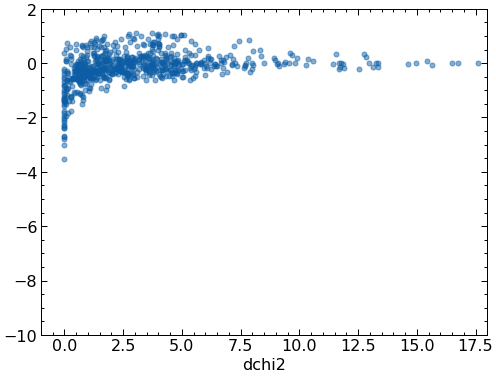

In [309]:
plt.errorbar((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']),
            np.log10(results_float['bayes.stellar.m_star'])-np.log10(results_fagn0['bayes.stellar.m_star']),
            ms=5, linestyle='none', marker='o', alpha=0.5)

# Show 0.3 dex

#plt.scatter(np.log10(results_float['best.stellar.m_star']),
#            np.log10(results_fagn0['best.stellar.m_star']))

plt.xlim(-1, 18)
plt.ylim(-10, 2)
plt.xlabel('dchi2')

Text(0, 0.5, '$M{_\\ast,f_{{\\rm{AGN}}=[0-1]}} - M{_\\ast,f_{{\\rm{AGN}}=0}}$')

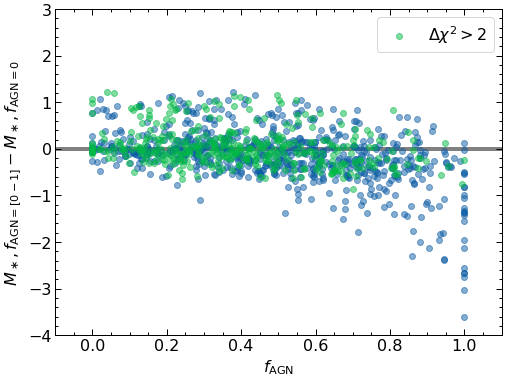

In [380]:
plt.scatter(np.clip(results_float['best.agn.fracAGN'] + np.random.normal(0,0.1,len(results_float)), 0, 1),
            np.log10(results_float['bayes.stellar.m_star']) - np.log10(results_fagn0['best.stellar.m_star']),
            alpha=0.5)


plt.scatter(np.clip((results_float['best.agn.fracAGN']+np.random.normal(0,0.1,len(results_float))), 0, 1)[mask_chi2],
            (np.log10(results_float['bayes.stellar.m_star']) - np.log10(results_fagn0['best.stellar.m_star']))[mask_chi2],
            alpha=0.5, label=r'$\Delta \chi^2 > 2$')

plt.plot([-0.1,1.1],[0,0], color='gray', lw=4, zorder=-1)

plt.xlim(-0.1, 1.1)
plt.ylim(-4, 3)

plt.legend(frameon=True)

plt.xlabel(r'$f_{\rm{AGN}}$')
plt.ylabel(r'$M{_\ast,f_{{\rm{AGN}}=[0-1]}} - M{_\ast,f_{{\rm{AGN}}=0}}$')

Text(0, 0.5, '$M{_\\ast,f_{{\\rm{AGN}}=[0-1]}}$')

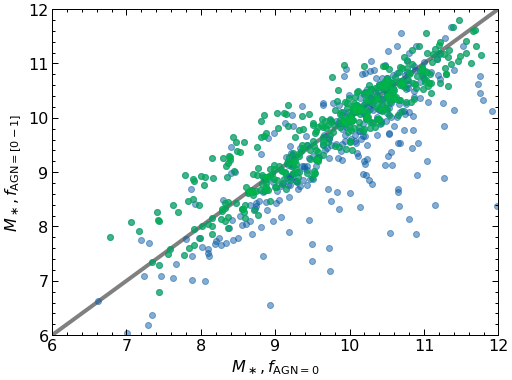

In [386]:
mask_chi2 = (results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) > 2


plt.scatter(np.log10(results_fagn0['best.stellar.m_star']),
            np.log10(results_float['bayes.stellar.m_star']),
            alpha=0.5)


plt.scatter(np.log10(results_fagn0['best.stellar.m_star'])[mask_chi2],
            np.log10(results_float['bayes.stellar.m_star'])[mask_chi2],
            alpha=0.5)

plt.plot([6,12],[6,12], color='gray', lw=4, zorder=-1)

plt.xlim(6, 12)
plt.ylim(6, 12)

plt.xlabel(r'$M{_\ast,f_{{\rm{AGN}}=0}}$')
plt.ylabel(r'$M{_\ast,f_{{\rm{AGN}}=[0-1]}}$')

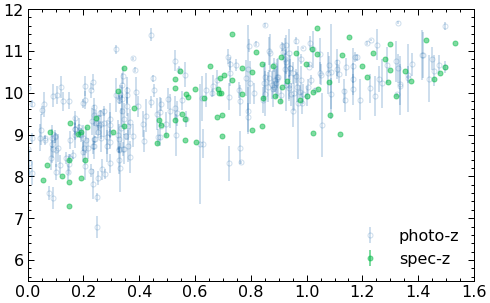

In [315]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))

dM = 0.434*results_float['bayes.stellar.m_star_err']/results_float['bayes.stellar.m_star']

ax.errorbar(z_ph[~mask_specz & mask_chi2]+np.random.normal(0, 0.1,len(z_ph[~mask_specz & mask_chi2])),# & mask_chi2],
             np.log10(results_float['bayes.stellar.m_star'][~mask_specz & mask_chi2]),# & mask_chi2]),
             yerr=dM[~mask_specz & mask_chi2],# & mask_chi2],
             marker='o', linestyle='none', mfc='none', ms=5, label='photo-z', alpha=0.2)

ax.errorbar(data_agn[r'$z_{\rm{sp}}$'][mask_specz & mask_chi2],
             np.log10(results_float['bayes.stellar.m_star'][mask_specz & mask_chi2]),
             yerr=0,
             marker='o', linestyle='none', ms=5, label='spec-z', alpha=0.5)

ax.set_ylim(5.5, 12)
ax.set_xlim(0, 1.6)

ax.legend()

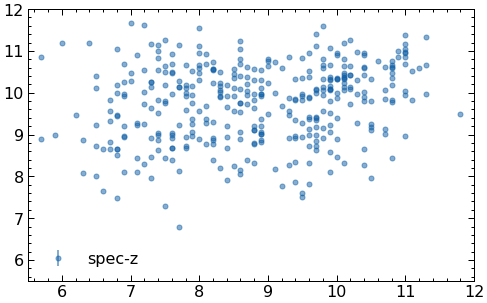

In [364]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))

M_star_Burke = np.array([d.split(' ')[0][1:] for d in data_agn[r'$\log\ \frac{M_{\ast}}{M_{\odot}}$']], dtype=float)

ax.errorbar(M_star_Burke[idx_des][mask_chi2],
            np.log10(results_float['bayes.stellar.m_star'][mask_chi2]),
            yerr=0,
            marker='o', linestyle='none', ms=5, label='spec-z', alpha=0.5)

ax.set_ylim(5.5, 12)
ax.set_xlim(5.5, 12)

ax.legend()

In [354]:
data_phot #['redshift']

array([[0.00000000e+00, 1.00000000e+00, 3.25939283e-03, ...,
        7.49886820e-05, 1.03256247e-04, 1.56431150e-04],
       [1.00000000e+00, 2.00000000e-01, 8.03462375e-04, ...,
        1.82812377e-04, 2.59342733e-04, 2.97197417e-04],
       [2.00000000e+00, 1.00000000e+00, 1.37354994e-03, ...,
        4.35736129e-05, 6.16335602e-05, 8.00714235e-05],
       ...,
       [7.03000000e+02, 1.44300000e-01, 7.27956046e-03, ...,
        3.89417713e-05, 6.14628268e-05, 8.54100856e-05],
       [7.04000000e+02, 6.94000000e-02, 2.66960065e-03, ...,
        3.77621419e-05, 5.20246822e-05, 8.14728593e-05],
       [7.05000000e+02, 1.90900000e-01, 8.09196986e-04, ...,
        6.14838608e-05, 7.47878068e-05, 1.05583508e-04]])

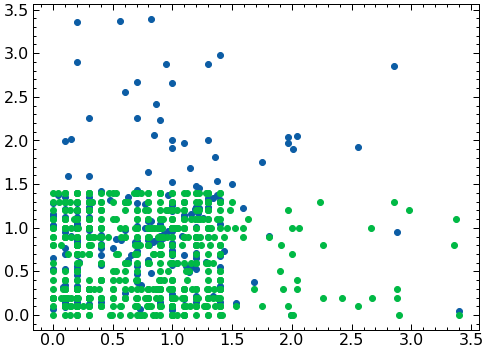

In [363]:
plt.scatter(data_phot[:,1], data_agn[idx_des][r'$z_{\rm{sp}}$'])
plt.scatter(data_phot[:,1], z_ph[idx_des])

In [316]:
len(data_agn[r'$z_{\rm{sp}}$'][mask_specz & mask_chi2])

104

In [336]:
mask_mass = np.log10(results_float['bayes.stellar.m_star']) < 9.5
data_agn[idx_des][mask_specz & mask_chi2 & mask_mass]

Name,RA,dec,$g$,SNR,$\sigma_{\rm{LB}}$,$\log\ \frac{M_{\ast}}{M_{\odot}}$,$\Delta\chi_\nu^2$,"$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$",$z_{\rm{ph}}$,$z_{\rm{sp}}$,$z_{\rm{sp}}$ source,$W1{-}W2$,$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\ s}}^{-1} {\rm{\ cm}}^{-2}}$,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,str22,float64,str4,float64,float64,str5
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,$0.60^{+0.25}_{-0.05}$,nan,None,nan,nan,SN-C3
J033112.06-272056.04,52.8003,-27.3489,24.1,9.8,10.2,$8.9 \pm 0.4$,0.3,$2.3 \pm 0.8$,$1.49^{+nan}_{-0.03}$,nan,None,nan,nan,SN-C3
J033011.41-272133.13,52.5475,-27.3592,23.3,15.3,13.5,$7.4 \pm 0.6$,0.0,$1.7 \pm 0.3$,$0.25^{+0.01}_{-0.02}$,nan,None,nan,nan,SN-C3
J033009.72-282139.05,52.5405,-28.3608,22.7,19.7,17.1,$9.7 \pm 0.4$,0.1,$3.0 \pm 0.7$,$1.40^{+0.15}_{-0.25}$,nan,None,1.1,nan,SN-C3
J033136.60-280524.71,52.9025,-28.0902,23.3,10.5,4.3,$9.0 \pm 0.5$,0.1,$0.0 \pm 0.4$,$0.47^{+0.01}_{-0.02}$,nan,None,18.4,nan,SN-C3
J033322.86-280313.09,53.3453,-28.0536,23.1,21.2,17.5,$8.4 \pm 0.7$,0.1,$2.6 \pm 0.7$,$0.30^{+0.01}_{-0.02}$,nan,None,0.8,nan,SN-C3
J033314.30-282004.95,53.3096,-28.3347,22.2,8.9,10.7,$10.7 \pm 0.3$,0.3,$1.6 \pm 0.2$,$1.10^{+0.10}_{-0.05}$,nan,None,0.8,nan,SN-C3
J033318.95-281625.73,53.329,-28.2738,22.8,20.2,17.2,$8.2 \pm 0.4$,0.2,$2.9 \pm 0.8$,$0.22^{+0.01}_{-0.01}$,nan,None,nan,nan,SN-C3
J033013.29-284602.16,52.5554,-28.7673,23.5,12.8,10.3,$9.4 \pm 0.7$,0.2,$2.1 \pm 0.5$,$0.75^{+0.02}_{-0.02}$,nan,None,1.2,nan,SN-C3


# Updated Code

read table

In [595]:
data_agn = ascii.read('des_agn_updated.txt')

cat_agn = SkyCoord(data_agn['RA'], data_agn['dec'], unit='deg')

data_agn[:5]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,1.02,0.03,0.04,nan,None,0.4,nan,SN-C3,-1.0,--,-1.0,-1.0
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,0.24,0.04,0.02,nan,None,18.6,nan,SN-C3,-1.0,--,-1.0,-1.0
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,1.09,0.02,0.02,nan,None,0.9,nan,SN-C3,-1.0,--,-1.0,-1.0
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,1.3,0.1,0.15,nan,None,1.1,nan,SN-C3,-1.0,--,-1.0,-1.0
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,0.6,0.25,0.05,nan,None,nan,nan,SN-C3,-1.0,--,-1.0,-1.0


## Prepare cigale inputs

### initialize data table used for cigale

In [596]:
data_phot = Table()
data_phot['id'] = np.arange(len(data_agn), dtype=np.int64) + 1

update redshifts

In [597]:
# initialize with all updated value
data_phot['redshift'] = data_agn['z_best']
# if no update, use z_sp instead
sp_mask = ~(data_phot['redshift']>0)
data_phot['redshift'][sp_mask] = data_agn['z_sp'][sp_mask]
# if no z_sp, use z_ph instead
ph_mask = ~(data_phot['redshift']>0)
data_phot['redshift'][ph_mask] = data_agn['z_ph'][ph_mask]

# count of data which still does not have a redshift
print(np.count_nonzero(~(data_phot['redshift']>0)))

data_phot[:5]

0


id,redshift
int64,float64
1,1.02
2,0.24
3,1.09
4,1.3
5,0.6


### Add Chandra data

Chandra query

readme: https://cdsarc.cds.unistra.fr/viz-bin/Cat?IX/57

documentaion: https://cdsarc.cds.unistra.fr/viz-bin/ReadMe/IX/57?format=html&tex=true

In [598]:
%%script true

properties = ['Flux', 'b_Flux', 'B_Flux']
bands = 'bhmsuw'
columns = ['RAICRS', 'DEICRS'] + [p + b for b, p in product(bands, properties)]
for c in columns: print(c, end=', ')

result = Vizier(columns=columns).query_region(cat_agn, width="3s", catalog=["IX/57"])
data_chandra = result[0]
ascii.write(data_chandra, 'data_chandra.txt', overwrite=True)

In [599]:
data_chandra = ascii.read('data_chandra.txt')
print(len(data_chandra))
data_chandra[:5]

64


_q,RAICRS,DEICRS,Fluxb,b_Fluxb,B_Fluxb,Fluxh,b_Fluxh,B_Fluxh,Fluxm,b_Fluxm,B_Fluxm,Fluxs,b_Fluxs,B_Fluxs,Fluxu,b_Fluxu,B_Fluxu,Fluxw,b_Fluxw,B_Fluxw
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
42,53.0169306,-27.6238773,3.210220063707e-14,3.066622628268e-14,3.345370591178e-14,1.799181548055e-14,1.656862789081e-14,1.941500307029e-14,5.719908310775e-15,5.31499562477e-15,6.12482099678e-15,8.514195275336e-15,7.881664910513e-15,9.107192492357e-15,5.619735347227e-15,2.305532450144e-15,8.933938244309e-15,--,--,--
43,53.1103179,-27.6766303,1.812614895823e-14,1.719648040879e-14,1.899383960438e-14,8.150737217958e-15,7.200438313841e-15,9.037682861802e-15,3.446788998374e-15,3.220598155041e-15,3.672979841707e-15,6.300749370778e-15,5.830429740204e-15,6.741674024442e-15,0.0,0.0,1.209916293954e-15,--,--,--
44,53.1124463,-27.6847878,1.014413464119e-13,1.003991263969e-13,1.024140850927e-13,5.320698680544e-14,5.222391226792e-14,5.412861918437e-14,1.858803517797e-14,1.831788471621e-14,1.885818563973e-14,2.979295780174e-14,2.922947490447e-14,3.032122301792e-14,4.281698761653e-14,3.600519413208e-14,4.962878110098e-14,--,--,--
45,53.1258705,-27.7513685,1.372551168222e-14,1.352855828595e-14,1.391015549123e-14,6.660623168515e-15,6.475197455836e-15,6.834459774152e-15,2.585920980462e-15,2.527105161135e-15,2.641060811082e-15,4.401534925358e-15,4.296878852736e-15,4.499649993442e-15,1.19283425774e-15,1.005483569584e-15,1.380184945896e-15,--,--,--
46,53.1249008,-27.7583895,8.595403890476e-15,8.389821566129e-15,8.788137319552e-15,5.917140271408e-15,5.699285121058e-15,6.12137947486e-15,1.581940455388e-15,1.522695443218e-15,1.637482654299e-15,1.136228462161e-15,1.073210969925e-15,1.195307361132e-15,0.0,0.0,1.077409861647e-16,--,--,--


generate and install boxcar filters

```python
# Chandra bands:
# b - ACIS broad (0.5-7.0keV) energy band *
# h - ACIS hard (2.0-7.0keV) energy band *
# m - ACIS medium (1.2-2.0keV) energy band
# s - ACIS soft (0.5-1.2keV) energy band
# u - ACIS ultrasoft (0.2-0.5keV) energy band
# w - HRC wide (∼0.1-10.0keV) energy band
# unit: ph/s/cm2 for PF and mW/m2 for Flux and avg
# note: mW/m2===erg/s/cm2
# * = cigale already have matched boxcar bands, which can be directly used
```

In [600]:
%%script true # skip this cell when running all if these filters are already generated

# generate and install filters
boxcars = [[0.5, 7], [2, 7], [1.2, 2], [0.5, 1.2], [0.2, 0.5], [0.1, 10]]
for lw, hw in boxcars:
    l = str(lw).replace('.', 'p')
    h = str(hw).replace('.', 'p')
    xray_filter.write_boxcar_filter(f'cigale/chandra.{l}to{h}.dat', f'chandra.{l}to{h}', lw, hw)
    os.system(f'pcigale-filters add cigale/chandra.{l}to{h}.dat')

convert and add chandra data to table

In [601]:
properties = ['Flux', 'b_Flux', 'B_Flux']
# actually no data in 0.1-10 boxcar
bands = 'bhmsuw'
boxcars = [[0.5, 7], [2, 7], [1.2, 2], [0.5, 1.2], [0.2, 0.5], [0.1, 10]]
cols_chandra = Table()
cols_chandra['id'] = data_chandra['_q']
for boxcar, band in zip(boxcars, bands):
    lw, hw = boxcar
    Fx = data_chandra['Flux'+band]
    Fx_err = (data_chandra['B_Flux'+band]-data_chandra['b_Flux'+band])/2
    Fnu, Fnu_err = convert_Fx.convt_Fx_to_Fnu(Fx, Fx_err, lw, hw)
    l = str(lw).replace('.', 'p')
    h = str(hw).replace('.', 'p')
    cols_chandra[f'chandra.{l}to{h}'] = Fnu
    cols_chandra[f'chandra.{l}to{h}_err'] = Fnu_err
data_phot = join(data_phot, cols_chandra, keys='id', join_type='left')

data_phot[45:50]

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
46,1.222,5.46888218643927e-07,1.2671550727749168e-08,4.894265175725867e-07,1.7456419840728817e-08,8.177975049756461e-07,2.9670110055479476e-08,6.712947638978172e-07,3.6067864358983434e-08,0.0,7.426348601934504e-08
47,1.21,3.9117910631293815e-07,1.343051183740461e-08,2.8504782549673323e-07,1.788399217273329e-08,6.092366010305493e-07,2.299993074056111e-08,9.062019548620903e-07,4.958044140613548e-08,1.9605808212139454e-06,5.041493540264431e-07
48,0.44,--,--,--,--,--,--,--,--,--,--
49,0.17,--,--,--,--,--,--,--,--,--,--
50,0.95,--,--,--,--,--,--,--,--,--,--


### get Newton XMM data 

column description: https://cdsarc.cds.unistra.fr/viz-bin/ReadMe/IX/69?format=html&tex=true

In [628]:
%%script true

properties = ['Flux', 'e_Flux']
bands = '123456789'
columns = ['RA_ICRS', 'DE_ICRS'] + [p + b for b, p in product(bands, properties)]
for c in columns: print(c, end=', ')

result = Vizier(columns=columns).query_region(cat_agn, width="3s", catalog=["IX/69/xmm4d13s"])
data_xmm = result[0]
ascii.write(data_xmm, 'data_xmm.txt', overwrite=True)

In [629]:
data_xmm = ascii.read('data_xmm.txt')
print(len(data_xmm))
data_xmm[:5]

426


_q,RA_ICRS,DE_ICRS,Flux1,e_Flux1,Flux2,e_Flux2,Flux3,e_Flux3,Flux4,e_Flux4,Flux5,e_Flux5,Flux8,e_Flux8,Flux9,e_Flux9
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,52.463052,-27.182635,4.9205e-16,1.7639e-16,8.2992e-16,2.27e-16,2.2566e-15,4.1768e-16,2.976e-16,4.6994e-16,3.1968e-15,3.928e-15,8.7687e-15,4.1107e-15,5.2264e-15,7.7563e-16
3,52.435785,-27.185378,1.2715e-15,2.3636e-16,1.7451e-15,2.8893e-16,2.9456e-15,4.2513e-16,3.1395e-15,8.0828e-16,4.5511e-15,4.3917e-15,1.6836e-14,4.5359e-15,8.8893e-15,8.5217e-16
5,52.18007,-27.188041,1.7301e-15,3.2788e-16,2.0494e-15,3.6986e-16,2.3217e-15,4.7699e-16,1.7426e-15,7.227e-16,1.0472e-14,5.2775e-15,1.9322e-14,5.3994e-15,7.5008e-15,9.5191e-16
6,52.20912,-27.202206,4.7127e-14,1.2972e-15,6.2927e-14,1.5489e-15,7.0163e-14,1.7425e-15,9.686e-14,3.5017e-15,1.5154e-13,1.1245e-14,4.2676e-13,1.2139e-14,2.3889e-13,3.7712e-15
8,52.19632,-27.264939,1.6483e-15,2.6977e-16,2.454e-15,3.4456e-16,2.5949e-15,4.1096e-16,1.4406e-15,6.4191e-16,5.0763e-15,3.9347e-15,1.3746e-14,4.0498e-15,8.4155e-15,8.6147e-16


create and install XMM filters

```python
1 = 0.2 -  0.5 keV (narrow band)
2 = 0.5 -  1.0 keV (narrow band)
3 = 1.0 -  2.0 keV (narrow band)
4 = 2.0 -  4.5 keV (narrow band)
5 = 4.5 - 12.0 keV (narrow band)
6 = 0.2 -  2.0 keV = soft broad band, no images made
7 = 2.0 - 12.0 keV = hard broad band, no images made
8 = 0.2 - 12.0 keV = total band
9 = 0.5 -  4.5 keV = XID band
```

In [641]:
%%script true # skip this cell when running all if these filters are already generated

# generate and install filters
boxcars = [[0.2, 0.5], [0.5, 1], [1, 2], [2, 4.5], [4.5, 12], [0.2, 2], [2, 12], [0.2, 12], [0.5, 4.5]] 
for lw, hw in boxcars:
    l = str(lw).replace('.', 'p')
    h = str(hw).replace('.', 'p')
    xray_filter.write_boxcar_filter(f'cigale/xmm.newton.{l}to{h}.dat', f'xmm.newton.{l}to{h}', lw, hw)
    os.system(f'pcigale-filters add cigale/xmm.newton.{l}to{h}.dat')

Importing xmm.newton.0p2to0p5... (100 points)
Importing xmm.newton.0p5to1... (100 points)
Importing xmm.newton.1to2... (100 points)
Importing xmm.newton.2to4p5... (100 points)
Importing xmm.newton.4p5to12... (100 points)
Importing xmm.newton.0p2to2... (100 points)
Importing xmm.newton.2to12... (100 points)
Importing xmm.newton.0p2to12... (100 points)
Importing xmm.newton.0p5to4p5... (100 points)


Add them to table

In [607]:
properties = ['Flux', 'e_Flux']
bands = '123456789'
boxcars = [[0.2, 0.5], [0.5, 1], [1, 2], [2, 4.5], [4.5, 12], [0.2, 2], [2, 12], [0.2, 12], [0.5, 4.5]] 
cols_xmm = Table()
cols_xmm['id'] = data_xmm['_q']
for boxcar, band in zip(boxcars, bands):
    if 'Flux'+band in data_xmm.colnames:
        lw, hw = boxcar
        Fx = data_xmm['Flux'+band]
        Fx_err = data_xmm['e_Flux'+band]
        Fnu, Fnu_err = convert_Fx.convt_Fx_to_Fnu(Fx, Fx_err, lw, hw)
        l = str(lw).replace('.', 'p')
        h = str(hw).replace('.', 'p')
        cols_xmm[f'xmm.newton.{l}to{h}'] = Fnu
        cols_xmm[f'xmm.newton.{l}to{h}_err'] = Fnu_err
data_phot = join(data_phot, cols_xmm, keys='id', join_type='left')

data_phot[45:50]

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err,xmm.newton.0p2to0p5,xmm.newton.0p2to0p5_err,xmm.newton.0p5to1,xmm.newton.0p5to1_err,xmm.newton.1to2,xmm.newton.1to2_err,xmm.newton.2to4p5,xmm.newton.2to4p5_err,xmm.newton.4p5to12,xmm.newton.4p5to12_err,xmm.newton.0p2to12,xmm.newton.0p2to12_err,xmm.newton.0p5to4p5,xmm.newton.0p5to4p5_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
46,1.222,5.46888218643927e-07,1.2671550727749168e-08,4.894265175725867e-07,1.7456419840728817e-08,8.177975049756461e-07,2.9670110055479476e-08,6.712947638978172e-07,3.6067864358983434e-08,0.0,7.426348601934504e-08,2.8538726364982677e-06,5.67275752428056e-08,2.059711397105171e-06,3.833044348869152e-08,1.4136911531717858e-06,2.454316130407161e-08,7.712027694515734e-07,2.034649250861812e-08,3.439552110177635e-07,2.35251667004738e-08,7.734364505842883e-07,1.711714306922322e-08,1.298372195110761e-06,1.3789556801853223e-08
47,1.21,3.9117910631293815e-07,1.343051183740461e-08,2.8504782549673323e-07,1.788399217273329e-08,6.092366010305493e-07,2.299993074056111e-08,9.062019548620903e-07,4.958044140613548e-08,1.9605808212139454e-06,5.041493540264431e-07,1.2272607676180543e-06,4.6319753916727015e-08,1.1375981133928458e-06,3.464043534278818e-08,7.678694212878528e-07,2.2955809328638294e-08,3.2212384837924175e-07,1.8103637203222373e-08,1.5055098688229904e-07,2.7086858863300586e-08,3.8938362807478024e-07,1.8694900295599673e-08,6.257172172922618e-07,1.2061778229770857e-08
48,0.44,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
49,0.17,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
50,0.95,--,--,--,--,--,--,--,--,--,--,7.972809113924763e-06,6.224152312752429e-07,5.647188069466379e-06,4.1535751380515396e-07,2.6136592711019402e-06,2.2629836000766754e-07,1.306952051314799e-06,1.7860790796059006e-07,1.3675329660064186e-06,3.6437713810517347e-07,1.820930982152442e-06,2.3768348166816682e-07,2.3659327760562015e-06,1.242954247971981e-07


### Add Galex data

Galex query

description: https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=II/335/galex_ais



In [608]:
%%script true

columns = ['RAJ2000', 'DEJ2000', 'Name', 'Fflux','e_Fflux', 'Nflux','e_Nflux']
# query the coordinates by slices if timeout
result1 = Vizier(columns=columns).query_region(cat_agn[:300], width="3s", catalog=["II/335"])
result2 = Vizier(columns=columns).query_region(cat_agn[300:600], width="3s", catalog=["II/335"])
result2[0]['_q'] += 300*5
result3 = Vizier(columns=columns).query_region(cat_agn[600:], width="3s", catalog=["II/335"])
result3[0]['_q'] += 600*5
data_galex = vstack([result1[0], result2[0], result3[0]])
for item in data_galex: item['_q'] = (item['_q']+4)//5
ascii.write(data_galex, 'data_galex.txt', overwrite=True)

In [609]:
data_galex = ascii.read('data_galex.txt')
print(len(data_galex))
data_galex[:5]

175


_q,RAJ2000,DEJ2000,Name,Fflux,e_Fflux,Nflux,e_Nflux
int64,float64,float64,str22,float64,float64,float64,float64
6,52.209116,-27.2022,GALEX J032850.1-271207,12.464,2.68449,38.6536,3.38508
14,52.605846,-27.472676,GALEX J033025.4-272821,17.0712,2.97083,26.0569,2.89944
15,52.654998,-27.484993,GALEX J033037.1-272905,4.77368,1.59496,13.2025,2.15967
18,52.037351,-27.355776,GALEX J032808.9-272120,4.25625,1.64429,16.4312,2.47282
20,52.214852,-27.414973,GALEX J032851.5-272453,--,--,4.0534,1.41491


In [610]:
factor = (1*u.uJy).to(u.mJy).value
cols_galex = Table()
cols_galex['id'] = data_galex['_q']
cols_galex['galex.FUV'] = data_galex['Fflux']*factor
cols_galex['galex.FUV_err'] = data_galex['e_Fflux']*factor
cols_galex['galex.NUV'] = data_galex['Nflux']*factor
cols_galex['galex.NUV_err'] = data_galex['e_Nflux']*factor
cols_galex = unique(cols_galex, keys='id', keep='first')
data_phot = join(data_phot, cols_galex, keys='id', join_type='left')

data_phot[45:50]

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err,xmm.newton.0p2to0p5,xmm.newton.0p2to0p5_err,xmm.newton.0p5to1,xmm.newton.0p5to1_err,xmm.newton.1to2,xmm.newton.1to2_err,xmm.newton.2to4p5,xmm.newton.2to4p5_err,xmm.newton.4p5to12,xmm.newton.4p5to12_err,xmm.newton.0p2to12,xmm.newton.0p2to12_err,xmm.newton.0p5to4p5,xmm.newton.0p5to4p5_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
46,1.222,5.46888218643927e-07,1.2671550727749168e-08,4.894265175725867e-07,1.7456419840728817e-08,8.177975049756461e-07,2.9670110055479476e-08,6.712947638978172e-07,3.6067864358983434e-08,0.0,7.426348601934504e-08,2.8538726364982677e-06,5.67275752428056e-08,2.059711397105171e-06,3.833044348869152e-08,1.4136911531717858e-06,2.454316130407161e-08,7.712027694515734e-07,2.034649250861812e-08,3.439552110177635e-07,2.35251667004738e-08,7.734364505842883e-07,1.711714306922322e-08,1.298372195110761e-06,1.3789556801853223e-08,--,--,0.00332002,0.00106587
47,1.21,3.9117910631293815e-07,1.343051183740461e-08,2.8504782549673323e-07,1.788399217273329e-08,6.092366010305493e-07,2.299993074056111e-08,9.062019548620903e-07,4.958044140613548e-08,1.9605808212139454e-06,5.041493540264431e-07,1.2272607676180543e-06,4.6319753916727015e-08,1.1375981133928458e-06,3.464043534278818e-08,7.678694212878528e-07,2.2955809328638294e-08,3.2212384837924175e-07,1.8103637203222373e-08,1.5055098688229904e-07,2.7086858863300586e-08,3.8938362807478024e-07,1.8694900295599673e-08,6.257172172922618e-07,1.2061778229770857e-08,--,--,--,--
48,0.44,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
49,0.17,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
50,0.95,--,--,--,--,--,--,--,--,--,--,7.972809113924763e-06,6.224152312752429e-07,5.647188069466379e-06,4.1535751380515396e-07,2.6136592711019402e-06,2.2629836000766754e-07,1.306952051314799e-06,1.7860790796059006e-07,1.3675329660064186e-06,3.6437713810517347e-07,1.820930982152442e-06,2.3768348166816682e-07,2.3659327760562015e-06,1.242954247971981e-07,--,--,--,--


### add the DES photometries

Match to DES photometry

Descripton see https://arxiv.org/pdf/2012.12824

In [611]:
data_des = Table.read('y3nir.fits')
cat_des = SkyCoord(data_des['RA']*u.deg, data_des['DEC']*u.deg)
idx_agn_des, d2d_agn_des, d3d_agn_des = cat_agn.match_to_catalog_sky(cat_des)

data_des[:5]

ID,RA,DEC,TILENAME,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_J,FLUX_H,FLUX_KS,FLUXERR_U,FLUXERR_G,FLUXERR_R,FLUXERR_I,FLUXERR_Z,FLUXERR_J,FLUXERR_H,FLUXERR_KS,KNN_CLASS
int64,float64,float64,bytes40,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
691667164,52.22639312930617,-27.12646591483214,SN-C3_C01,38.938325338515995,62.23159918283658,77.31811011109916,75.84423229529766,60.824881979263075,138.54984121413045,38.62186829066135,149.44992776043622,16.230021522734038,4.872166388451744,6.412164342753529,9.731861297323734,16.023497425714723,13.122682624349347,17.016402069277415,24.8571214378777,1.0
691667165,52.43641175853804,-27.127414217274232,SN-C3_C01,1212.5391048482684,3075.8225727221,7041.893319632975,9837.49499818031,11804.79997679652,17411.458251373708,20283.06865550826,23611.158407678708,25.437629615552375,8.8246559075431,15.095996545211573,22.988570746346593,36.11540892261989,28.659104867099263,39.23530359257762,53.72874124345837,1.0
691667166,52.18629345944041,-27.12556992076869,SN-C3_C01,49.872559586645195,34.16915160442107,62.426155983806325,88.38896983371535,125.8600959489068,152.2430878156623,70.31102355733086,237.8472278984986,17.511565153413102,5.008401804843428,7.158538630010853,11.182541030977903,19.36197096626383,21.8747894517918,25.84411336037444,47.431546426644196,1.0
691667174,52.36223314495355,-27.123560376037414,SN-C3_C01,35.756508474337764,42.250782372666855,76.43711296749481,58.90125172325419,34.91538352911582,167.36822642241714,196.71231322379077,176.8388786192518,17.985178171553688,7.824433382171552,10.977604988798198,13.961241963001573,22.535490525644946,15.34619313767736,21.33203095312637,28.064098325798035,1.0
691667167,52.28056175889396,-27.12872746158443,SN-C3_C01,59.34250910224647,10.694164278686387,86.84797664584849,102.01487359071042,183.61852676547684,335.52558207270727,175.10988112729615,393.8394708037967,23.08729966953069,6.394948716743078,13.309700506208262,18.666961621296398,34.783037203244746,331.4846565788875,45.52896079582857,637.9505307112591,1.0


install filters

In [612]:
%%script true

# generate filter files
decam_filers = ascii.read('DECam_filters_transmission.txt')
for band in 'ugriz':
    filter = decam_filers[['wavelength(nm)', band]]
    filter['wavelength(nm)']*=10 # nm to Angstrom
    filter.meta['comments'] = [f'ctio.decam.{band}', 'energy', 'decam filter downloaded from https://www.ctio.noirlab.edu/noao/sites/default/files/DECam/DECam_filters_transmission.txt']
    filter.write(f'cigale/ctio.decam.{band}.dat', format='ascii.no_header', overwrite=True)

# install filters
for band in 'ugriz':
    os.system(f'pcigale-filters add cigale/ctio.decam.{band}.dat')

add photometries

In [613]:
factor = (3.63*u.nJy).to(u.mJy).value
data_phot['ctio.decam.u'] = data_des['FLUX_U'][idx_agn_des]*factor
data_phot['ctio.decam.u_err'] = data_des['FLUXERR_U'][idx_agn_des]*factor
data_phot['ctio.decam.g'] = data_des['FLUX_G'][idx_agn_des]*factor
data_phot['ctio.decam.g_err'] = data_des['FLUXERR_G'][idx_agn_des]*factor
data_phot['ctio.decam.r'] = data_des['FLUX_R'][idx_agn_des]*factor
data_phot['ctio.decam.r_err'] = data_des['FLUXERR_R'][idx_agn_des]*factor
data_phot['ctio.decam.i'] = data_des['FLUX_I'][idx_agn_des]*factor
data_phot['ctio.decam.i_err'] = data_des['FLUXERR_I'][idx_agn_des]*factor
data_phot['ctio.decam.z'] = data_des['FLUX_Z'][idx_agn_des]*factor
data_phot['ctio.decam.z_err'] = data_des['FLUXERR_Z'][idx_agn_des]*factor
data_phot['vista.vircam.J'] = data_des['FLUX_J'][idx_agn_des]*factor
data_phot['vista.vircam.J_err'] = data_des['FLUXERR_J'][idx_agn_des]*factor
data_phot['vista.vircam.H'] = data_des['FLUX_H'][idx_agn_des]*factor
data_phot['vista.vircam.H_err'] = data_des['FLUXERR_H'][idx_agn_des]*factor
data_phot['vista.vircam.Ks'] = data_des['FLUX_KS'][idx_agn_des]*factor
data_phot['vista.vircam.Ks_err'] = data_des['FLUXERR_KS'][idx_agn_des]*factor

data_phot[40:50]

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err,xmm.newton.0p2to0p5,xmm.newton.0p2to0p5_err,xmm.newton.0p5to1,xmm.newton.0p5to1_err,xmm.newton.1to2,xmm.newton.1to2_err,xmm.newton.2to4p5,xmm.newton.2to4p5_err,xmm.newton.4p5to12,xmm.newton.4p5to12_err,xmm.newton.0p2to12,xmm.newton.0p2to12_err,xmm.newton.0p5to4p5,xmm.newton.0p5to4p5_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,ctio.decam.u,ctio.decam.u_err,ctio.decam.g,ctio.decam.g_err,ctio.decam.r,ctio.decam.r_err,ctio.decam.i,ctio.decam.i_err,ctio.decam.z,ctio.decam.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
41,0.24,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0024047161598741954,3.687690990768833e-05,0.0022494073413215116,1.4357318464751567e-05,0.0028941101181175505,1.924960298559946e-05,0.0033522789432988446,2.9578694356391154e-05,0.0041526779181026326,5.629685153090413e-05,0.0042047405494501635,5.907993495647587e-05,0.005249117872603707,7.53539877343543e-05,0.008917532401074617,9.664246310846801e-05
42,0.966,2.042523602690752e-06,8.867761121463203e-08,1.4881634018385047e-06,1.1771661883101284e-07,2.9569550037798096e-06,2.093230394481938e-07,5.030268909358405e-06,3.620267737086746e-07,7.747119313595964e-06,4.568813954171855e-06,4.247137726914947e-06,1.0040835960212551e-07,3.820149336990144e-06,7.578735124643879e-08,2.6496643940713596e-06,5.0407999290726146e-08,1.5514295658178347e-06,4.5652146865971576e-08,9.830592400059929e-07,8.15443385361467e-08,1.6073552888345215e-06,5.4400502789273776e-08,2.178969578647516e-06,2.6919991564509207e-08,--,--,--,--,0.0038200337296750626,3.242374599083383e-05,0.0039043311955976375,1.3378200510681627e-05,0.005187716605942899,1.7946036918487595e-05,0.006481359009727308,2.857300770409092e-05,0.006815574771589345,5.2569024291224655e-05,0.015349673186626495,5.891659519265184e-05,0.0103708518250607,7.14845949986276e-05,0.016572241178103034,0.00010491745117854639
43,1.04367995262146,1.1532881340951057e-06,5.7179079730543207e-08,6.741748123684788e-07,7.598232928351785e-08,1.7818467398359864e-06,1.1693127051403171e-07,3.7225436627342714e-06,2.691859678806857e-07,0.0,8.339686221478984e-07,1.7478020965149716e-05,1.446532490353058e-07,6.8123297297207375e-06,7.709438766537461e-08,2.6264715696270105e-06,3.986415585409574e-08,1.0229706389707465e-06,2.9319071717156246e-08,2.740287901758153e-07,3.7528041242134354e-08,1.5061856415977384e-06,2.6865122119060736e-08,2.5210823497063e-06,2.2171107739823962e-08,0.0109879,0.00213869,0.033600200000000004,0.00276653,0.04939439974866766,6.249178687949267e-05,0.03918550822148638,3.0847215452962354e-05,0.048772743491040625,4.259760374320775e-05,0.04865772174927495,6.53835749115661e-05,0.054412265602632535,0.00011814565784005356,0.05339560629836965,0.00018232468307464162,0.05320745730018647,0.00022548636994841606,0.06264361555242073,0.00031853364639154464
44,0.7366999983787537,6.454272299817813e-06,6.410153529889124e-08,4.400928331638243e-06,7.877234866469693e-08,9.609242079351855e-06,1.3965656725123726e-07,1.7601967596638825e-05,3.225076718551964e-07,5.902561085509067e-05,9.390438090585427e-06,4.375770777848269e-05,2.126243261901484e-07,2.8427504475053403e-05,1.3796256583522238e-07,1.3779052205903035e-05,7.49775875113811e-08,6.748996114610044e-06,5.821250051494509e-08,3.862189777685273e-06,7.643596179690635e-08,7.5341000548240445e-06,5.153602718868406e-08,1.234000527408141e-05,4.136867040555967e-08,0.0160185,0.00253

### Add WISE data

WISE query

column description: https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd?mode=html&catalog=allwise_p3as_psd

conversion from magnitude to flux density: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example

In [614]:
# data_wise = []
# for i, coord in enumerate(cat_agn):
#     item = Irsa.query_region(coordinates=coord, catalog='allwise_p3as_psd', radius='0d0m3s')
#     if len(item)>0: 
#         item.add_column(0, name='ID')
#         item[0]['ID'] = i+1
#         data_wise = vstack([data_wise, item[0]])
#     print(i+1, end='\t')
# print(end='\n')
# data_wise = data_wise[['ID']+[name for name in data_wise.colnames if name!='ID']]
# ascii.write(data_wise, 'data_wise.txt', overwrite=True)

# data_wise = ascii.read('data_wise.txt')
# print(len(data_wise))
# data_wise[:5]

In [615]:
# NOTE: use WISE data contained in Spitzer data

# def vega_to_mjy(mag, magerr, band): 
#     F0dict = {1:309.540, 2:171.787, 3:31.674, 4:8.363}
#     F0 = F0dict[band]
#     flux = F0*np.power(10, -mag/2.5)*1000
#     b_flux = F0*np.power(10, -(mag+magerr)/2.5)*1000
#     B_flux = F0*np.power(10, -(mag-magerr)/2.5)*1000
#     fluxerr = (B_flux - b_flux)/2
#     return flux, fluxerr

# cols_wise = table.Table()
# cols_wise['id'] = data_wise['ID']
# for band in [1, 2, 3, 4]: 
#     flux, fluxerr = vega_to_mjy(data_wise[f'w{band}mpro'], data_wise[f'w{band}sigmpro'], band)
#     cols_wise[f'WISE{band}'] = flux
#     cols_wise[f'WISE{band}_err'] = fluxerr
# data_phot = join(data_phot, cols_wise, keys='id', join_type='left')

# data_phot[45:50]

### Add Spitzer data

descripion: https://irsa.ipac.caltech.edu/data/SPITZER/Enhanced/SEIP/docs/Spitzer_EIP_expsup.pdf

Spitzer query

In [631]:
%%script true

data_spitzer = []
for i, coord in enumerate(cat_agn):
    item = result = Irsa.query_region(coordinates=coord, catalog='slphotdr4', radius='0d0m1s')
    if len(item)>0: 
        item.add_column(0, name='ID')
        item[0]['ID'] = i+1
        data_spitzer = vstack([data_spitzer, item[0]])
    print(i+1, end='\t')
print(end='\n')
data_spitzer = data_spitzer[['ID']+[name for name in data_spitzer.colnames if name!='ID']]
ascii.write(data_spitzer, 'data_spitzer.txt', overwrite=True)

In [633]:
data_spitzer = ascii.read('data_spitzer.txt')
print(len(data_spitzer))
data_spitzer[:5]

670


ID,col0,objid,crowded,badbkgmatch,ra,dec,l,b,nmatches,nreject,nbands,i1_fluxtype,i2_fluxtype,i3_fluxtype,i4_fluxtype,m1_fluxtype,i1_fluxflag,i2_fluxflag,i3_fluxflag,i4_fluxflag,m1_fluxflag,i1_softsatflag,i2_softsatflag,i3_softsatflag,i4_softsatflag,i1_f_ap1,i1_df_ap1,i1_f_ap2,i1_df_ap2,i1_f_ap1_bf,i1_df_ap1_bf,i1_f_ap2_bf,i1_df_ap2_bf,i1_f_ap1_3siglim,i1_f_ap2_3siglim,i2_f_ap1,i2_df_ap1,i2_f_ap2,i2_df_ap2,i2_f_ap1_bf,i2_df_ap1_bf,i2_f_ap2_bf,i2_df_ap2_bf,i2_f_ap1_3siglim,i2_f_ap2_3siglim,i3_f_ap1,i3_df_ap1,i3_f_ap2,i3_df_ap2,i3_f_ap1_bf,i3_df_ap1_bf,i3_f_ap2_bf,i3_df_ap2_bf,i3_f_ap1_3siglim,i3_f_ap2_3siglim,i4_f_ap1,i4_df_ap1,i4_f_ap2,i4_df_ap2,i4_f_ap1_bf,i4_df_ap1_bf,i4_f_ap2_bf,i4_df_ap2_bf,i4_f_ap1_3siglim,i4_f_ap2_3siglim,m1_f_psf,m1_df_psf,m1_f_ap,m1_df_ap,m1_f_psf_bf,m1_df_psf_bf,m1_f_ap_bf,m1_df_ap_bf,m1_f_psf_3siglim,m1_f_ap_3siglim,i1_extfrac,i2_extfrac,i3_extfrac,i4_extfrac,m1_extfrac,i1_brtfrac,i2_brtfrac,i3_brtfrac,i4_brtfrac,m1_brtfrac,i1_snr,i2_snr,i3_snr,i4_snr,m1_snr,i1_x,i1_y,i2_x,i2_y,i3_x,i3_y,i4_x,i4_y,m1_x,m1_y,i1_ra,i1_dec,i2_ra,i2_dec,i3_ra,i3_dec,i4_ra,i4_dec,m1_ra,m1_dec,i1_peakflux,i2_peakflux,i3_peakflux,i4_peakflux,i1_peakdist,i2_peakdist,i3_peakdist,i4_peakdist,i1_fwhm,i2_fwhm,i3_fwhm,i4_fwhm,m1_fwhm,i1_a,i1_b,i2_a,i2_b,i3_a,i3_b,i4_a,i4_b,i1_seflags,i2_seflags,i3_seflags,i4_seflags,m1_dflag,m1_sflag,i1_gain,i2_gain,i3_gain,i4_gain,m1_gain,i1_meannoise,i2_meannoise,i3_meannoise,i4_meannoise,m1_meannoise,i1_area,i2_area,i3_area,i4_area,m1_area,smid,regid,irac_obstype,mips_obstype,i1_coverage,i2_coverage,i3_coverage,i4_coverage,m1_coverage,twomass_key,twomass_assoc,twomass_ra,twomass_dec,j,dj,h,dh,k,dk,wise_ra,wise_dec,wise1,dwise1,wise2,dwise2,wise3,dwise3,wise4,dwise4,wise_cc_flags,wise_ext_flg,wise_var_flg,wise_ph_qual,wise_det_bit,wise1rchi2,wise1m,wise1nm,wise2rchi2,wise2m,wise2nm,wise3rchi2,wise3m,wise3nm,wise4rchi2,wise4m,wise4nm,x,y,z,spt_ind,htm20,cntr
int64,int64,str26,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str1,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str11,int64,int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,int64,str4,str4,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,float64,float64,int64,int64,int64
1,--,SSTSL2 J032833.77-271056.3,0,0,52.140722,-27.182308,222.268284,-55.196465,1,0,5,1,1,1,1,3,0,0,0,0,0,0,0,0,0,49.519,0.614,53.286,0.902,--,--,--,--,--,--,48.307,0.922,50.315,1.415,--,--,--,--,--,--,53.968,3.203,76.914,4.5,--,--,--,--,--,--,24.233,5.898,20.913,7.866,--,--,--,--,--,--,--,--,--,--,--,--,--,--,126.821,118.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.6,52.4,16.9,4.1,--,2744.94,1479.46,2744.45,1479.31,2744.0,1479.48,2745.31,1479.38,--,--,52.140722,-27.182308,52.140813,-27.182332,52.140899,-27.182305,52.140652,-27.182322,--,--

In [618]:
factor = (1*u.uJy).to(u.mJy).value
cols_spitzer = Table()
cols_spitzer['id'] = data_spitzer['ID']
cols_spitzer['spitzer.irac.ch1'] = data_spitzer['i1_f_ap1']*factor
cols_spitzer['spitzer.irac.ch1_err'] = data_spitzer['i1_df_ap1']*factor
cols_spitzer['spitzer.irac.ch2'] = data_spitzer['i2_f_ap1']*factor
cols_spitzer['spitzer.irac.ch2_err'] = data_spitzer['i2_df_ap1']*factor
cols_spitzer['spitzer.irac.ch3'] = data_spitzer['i3_f_ap1']*factor
cols_spitzer['spitzer.irac.ch3_err'] = data_spitzer['i3_df_ap1']*factor
cols_spitzer['spitzer.irac.ch4'] = data_spitzer['i4_f_ap1']*factor
cols_spitzer['spitzer.irac.ch4_err'] = data_spitzer['i4_df_ap1']*factor
cols_spitzer['spitzer.mips.24'] = data_spitzer['m1_f_ap']*factor
cols_spitzer['spitzer.mips.24_err'] = data_spitzer['m1_df_ap']*factor
cols_spitzer['WISE1'] = data_spitzer['wise1']*factor
cols_spitzer['WISE1_err'] = data_spitzer['dwise1']*factor
cols_spitzer['WISE2'] = data_spitzer['wise2']*factor
cols_spitzer['WISE2_err'] = data_spitzer['dwise2']*factor
cols_spitzer['WISE3'] = data_spitzer['wise3']*factor
cols_spitzer['WISE3_err'] = data_spitzer['dwise3']*factor
cols_spitzer['WISE4'] = data_spitzer['wise4']*factor
cols_spitzer['WISE4_err'] = data_spitzer['dwise4']*factor

cols_spitzer = unique(cols_spitzer, keys='id', keep='first')
data_phot = join(data_phot, cols_spitzer, keys='id', join_type='left')

data_phot[40:50]

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err,xmm.newton.0p2to0p5,xmm.newton.0p2to0p5_err,xmm.newton.0p5to1,xmm.newton.0p5to1_err,xmm.newton.1to2,xmm.newton.1to2_err,xmm.newton.2to4p5,xmm.newton.2to4p5_err,xmm.newton.4p5to12,xmm.newton.4p5to12_err,xmm.newton.0p2to12,xmm.newton.0p2to12_err,xmm.newton.0p5to4p5,xmm.newton.0p5to4p5_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,ctio.decam.u,ctio.decam.u_err,ctio.decam.g,ctio.decam.g_err,ctio.decam.r,ctio.decam.r_err,ctio.decam.i,ctio.decam.i_err,ctio.decam.z,ctio.decam.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,WISE1,WISE1_err,WISE2,WISE2_err,WISE3,WISE3_err,WISE4,WISE4_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
41,0.24,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0024047161598741954,3.687690990768833e-05,0.0022494073413215116,1.4357318464751567e-05,0.0028941101181175505,1.924960298559946e-05,0.0033522789432988446,2.9578694356391154e-05,0.0041526779181026326,5.629685153090413e-05,0.0042047405494501635,5.907993495647587e-05,0.005249117872603707,7.53539877343543e-05,0.008917532401074617,9.664246310846801e-05,0.015059,0.000413,0.016463000000000002,0.000819,0.028444,0.002524,0.035414,0.005899,0.186273,0.033192,0.018759,0.002903,0.02038,0.006495,0.16428600000000002,--,1.063653,--
42,0.966,2.042523602690752e-06,8.867761121463203e-08,1.4881634018385047e-06,1.1771661883101284e-07,2.9569550037798096e-06,2.093230394481938e-07,5.030268909358405e-06,3.620267737086746e-07,7.747119313595964e-06,4.568813954171855e-06,4.247137726914947e-06,1.0040835960212551e-07,3.820149336990144e-06,7.578735124643879e-08,2.6496643940713596e-06,5.0407999290726146e-08,1.5514295658178347e-06,4.5652146865971576e-08,9.830592400059929e-07,8.15443385361467e-08,1.6073552888345215e-06,5.4400502789273776e-08,2.178969578647516e-06,2.6919991564509207e-08,--,--,--,--,0.0038200337296750626,3.242374599083383e-05,0.0039043311955976375,1.3378200510681627e-05,0.005187716605942899,1.7946036918487595e-05,0.006481359009727308,2.857300770409092e-05,0.006815574771589345,5.2569024291224655e-05,0.015349673186626495,5.891659519265184e-05,0.0103708518250607,7.14845949986276e-05,0.016572241178103034,0.00010491745117854639,0.020578,0.000549,0.017927,0.000832,0.040958,0.003046,0.018460999999999998,0.005896,--,--,0.020777999999999998,0.0031000000000000003,0.013465,0.006684000000000001,0.183485,--,1.638325,--
43,1.04367995262146,1.1532881340951057e-06,5.7179079730543207e-08,6.741748123684788e-07,7.598232928351785e-08,1.7818467398359864e-06,1.1693127051403171e-07,3.7225436627342714e-06,2.691859678806857e-07,0.0,8.339686221478984e-07,1.7478020965149716e-05,1.446532490353058e-07,6.8123297297207375e-06,7.709438766537461e-08,2.6264715696270105e-06,3.986415585409574e-08,1.0229706389707465e-06,2.9319071717156246e-08,2.740287901758153e-07,3.7528041242134354e-08,1.5061856415977384e-06,2.6865122119060736e-08,2.5210823497063e-06,2.2171107739823962e-08,0.0109879,0.00213869,0.033600200000000004,0.00276653,0.04939439974866766,6.249178687949267e-05,0.03918550822148638,3.0847215452962354e-05,0.048772743491040625,4.259760374320775e-05,0.04865772174927495,6.538357491

## export data table in cigale form

set all invalid data entries to -9999 and set all -9999 error entries to 0

In [634]:
data_phot = data_phot.filled(fill_value=-9999.)

# clear invalid entries
for colname in data_phot.colnames[2:]:
    mask_invalid = ~(data_phot[colname]>0)
    data_phot[colname][mask_invalid] = -9999.

# clear invalid error values
for col_err in [col for col in data_phot.colnames if col[-4:]=='_err']:
    col = col_err[:-4]
    mask_invalid = (data_phot[col]>=0) & (data_phot[col_err]<0)
    data_phot[col_err][mask_invalid] = 0.

# TODO: remove empty bands

data_phot[40:50]

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err,xmm.newton.0p2to0p5,xmm.newton.0p2to0p5_err,xmm.newton.0p5to1,xmm.newton.0p5to1_err,xmm.newton.1to2,xmm.newton.1to2_err,xmm.newton.2to4p5,xmm.newton.2to4p5_err,xmm.newton.4p5to12,xmm.newton.4p5to12_err,xmm.newton.0p2to12,xmm.newton.0p2to12_err,xmm.newton.0p5to4p5,xmm.newton.0p5to4p5_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,ctio.decam.u,ctio.decam.u_err,ctio.decam.g,ctio.decam.g_err,ctio.decam.r,ctio.decam.r_err,ctio.decam.i,ctio.decam.i_err,ctio.decam.z,ctio.decam.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,WISE1,WISE1_err,WISE2,WISE2_err,WISE3,WISE3_err,WISE4,WISE4_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
41,0.24,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0024047161598741954,3.687690990768833e-05,0.0022494073413215116,1.4357318464751567e-05,0.0028941101181175505,1.924960298559946e-05,0.0033522789432988446,2.9578694356391154e-05,0.0041526779181026326,5.629685153090413e-05,0.0042047405494501635,5.907993495647587e-05,0.005249117872603707,7.53539877343543e-05,0.008917532401074617,9.664246310846801e-05,0.015059,0.000413,0.016463000000000002,0.000819,0.028444,0.002524,0.035414,0.005899,0.186273,0.033192,0.018759,0.002903,0.02038,0.006495,0.16428600000000002,0.0,1.063653,0.0
42,0.966,2.042523602690752e-06,8.867761121463203e-08,1.4881634018385047e-06,1.1771661883101284e-07,2.9569550037798096e-06,2.093230394481938e-07,5.030268909358405e-06,3.620267737086746e-07,7.747119313595964e-06,4.568813954171855e-06,4.247137726914947e-06,1.0040835960212551e-07,3.820149336990144e-06,7.578735124643879e-08,2.6496643940713596e-06,5.0407999290726146e-08,1.5514295658178347e-06,4.5652146865971576e-08,9.830592400059929e-07,8.15443385361467e-08,1.6073552888345215e-06,5.4400502789273776e-08,2.178969578647516e-06,2.6919991564509207e-08,-9999.0,-9999.0,-9999.0,-9999.0,0.0038200337296750626,3.242374599083383e-05,0.0039043311955976375,1.3378200510681627e-05,0.005187716605942899,1.7946036918487595e-05,0.006481359009727308,2.857300770409092e-05,0.006815574771589345,5.2569024291224655e-05,0.015349673186626495,5.891659519265184e-05,0.0103708518250607,7.14845949986276e-05,0.016572241178103034,0.00010491745117854639,0.020578,0.000549,0.017927,0.000832,0.040958,0.003046,0.018460999999999998,0.005896,-9999.0,-9999.0,0.020777999999999998,0.0031000000000000003,0.013465,0.006684000000000001,0.183485,0.0,1.638325,0.0
43,1.04367995262146,1.1532881340951057e-06,5.7179079730543207e-08,6.741748123684788e-07,7.598232928351785e-08,1.7818467398359864e-06,1.1693127051403171e-07,3.7225436627342714e-06,2.691859678806857e-07,-9999.0,8.339686221478984e-07,1.7478020965149716e-05,1.446532490353058e-07,6.8123297297207375e-06,7.709438766537461e-08,2.6264715696270105e-06,3.986415585409574e-08,1.0229706389707465e-06,2.9319071717156246e-08,2.740287901758153e-07,3.7528041242134354e-08,1.5061856415977384e-06,2.6865122119060736e-08,2.5210823497063e-06,2.2171107739823962e-08,0.0109879,0.00213869,0.03360020000

save table

In [642]:
data_phot.write('cigale/des/data_phot.dat', format='ascii.csv', delimiter=' ', overwrite=True)

# print filter names
print('Do not forget to add the following filter names to pcigale.ini: ')
for col in data_phot.colnames[2:]: print(col, end=', ')

Do not forget to add the following bands to pcigale.ini: 
chandra.0p5to7, chandra.0p5to7_err, chandra.2to7, chandra.2to7_err, chandra.1p2to2, chandra.1p2to2_err, chandra.0p5to1p2, chandra.0p5to1p2_err, chandra.0p2to0p5, chandra.0p2to0p5_err, xmm.newton.0p2to0p5, xmm.newton.0p2to0p5_err, xmm.newton.0p5to1, xmm.newton.0p5to1_err, xmm.newton.1to2, xmm.newton.1to2_err, xmm.newton.2to4p5, xmm.newton.2to4p5_err, xmm.newton.4p5to12, xmm.newton.4p5to12_err, xmm.newton.0p2to12, xmm.newton.0p2to12_err, xmm.newton.0p5to4p5, xmm.newton.0p5to4p5_err, galex.FUV, galex.FUV_err, galex.NUV, galex.NUV_err, ctio.decam.u, ctio.decam.u_err, ctio.decam.g, ctio.decam.g_err, ctio.decam.r, ctio.decam.r_err, ctio.decam.i, ctio.decam.i_err, ctio.decam.z, ctio.decam.z_err, vista.vircam.J, vista.vircam.J_err, vista.vircam.H, vista.vircam.H_err, vista.vircam.Ks, vista.vircam.Ks_err, spitzer.irac.ch1, spitzer.irac.ch1_err, spitzer.irac.ch2, spitzer.irac.ch2_err, spitzer.irac.ch3, spitzer.irac.ch3_err, spitzer.irac.c

# Do SED Fitting 



```shell
pcigale run
pcigale-plots sed
```

# Make some plots

in case the notebook is closed after doing fitting:

In [8]:
data_agn = ascii.read('des_agn_updated.txt')
cat_agn = SkyCoord(data_agn['RA'], data_agn['dec'], unit='deg')
data_des = Table.read('y3nir.fits')
cat_des = SkyCoord(data_des['RA']*u.deg, data_des['DEC']*u.deg)
idx_agn_des, d2d_agn_des, d3d_agn_des = cat_agn.match_to_catalog_sky(cat_des)
data_phot = ascii.read('cigale/des/data_phot.dat')
data_chandra = ascii.read('data_chandra.txt')
data_xmm = ascii.read('data_xmm.txt')
data_galex = ascii.read('data_galex.txt')
data_spitzer = ascii.read('data_spitzer.txt')

In [55]:
data_phot

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err,xmm.newton.0p2to0p5,xmm.newton.0p2to0p5_err,xmm.newton.0p5to1,xmm.newton.0p5to1_err,xmm.newton.1to2,xmm.newton.1to2_err,xmm.newton.2to4p5,xmm.newton.2to4p5_err,xmm.newton.4p5to12,xmm.newton.4p5to12_err,xmm.newton.0p2to12,xmm.newton.0p2to12_err,xmm.newton.0p5to4p5,xmm.newton.0p5to4p5_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,ctio.decam.u,ctio.decam.u_err,ctio.decam.g,ctio.decam.g_err,ctio.decam.r,ctio.decam.r_err,ctio.decam.i,ctio.decam.i_err,ctio.decam.z,ctio.decam.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,WISE1,WISE1_err,WISE2,WISE2_err,WISE3,WISE3_err,WISE4,WISE4_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1.02,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0008032896460231528,7.590688135295232e-05,0.0013163325280635104,1.6472165090050196e-05,0.002173463244116507,2.1944114686963572e-05,0.0031526614544590513,3.579858072233029e-05,0.005009728864800938,6.512359844665794e-05,0.005997794395643373,0.00018558643726299757,0.009719915705767515,0.0002627762867158613,0.01931272405273045,0.00029943104889366897,0.049519,0.000614,0.048307,0.0009220000000000001,0.053968,0.003203,0.024233,0.005898,-9999.0,-9999.0,0.040888,0.0032010000000000003,0.029813,0.0064800000000000005,0.149968,0.0,1.102554,0.0
2,0.24,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,6.783156729786637e-07,2.431620964642342e-07,6.86453012739131e-07,1.8775848630680383e-07,9.33250636820141e-07,1.7273939549865512e-07,4.9230822837473726e-08,7.774112337981954e-08,1.7628035418076133e-07,2.1660090853633057e-07,3.073270742434247e-07,1.440719423876687e-07,5.403642734462229e-07,8.019369839412632e-08,-9999.0,-9999.0,-9999.0,-9999.0,0.0013732546526433959,4.94215392059272e-05,0.0016412360461274878,1.6442413685831735e-05,0.0015989142653076432,2.30331724280241e-05,0.0024368051456875703,3.736079507220424e-05,0.0021077423001598736,7.076393199492252e-05,0.00467573614183411,4.3767823155762346e-05,0.006327461415900535,6.192133286787478e-05,0.007927952010727735,8.045975594802534e-05,0.01235,0.000507,0.015982,0.0007650000000000001,0.034688000000000004,0.00311,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,1.09,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1.7528889677821878e-06,3.258299580580452e-07,1.4434059255741837e-06,2.389836935344421e-07,1.2181857341351043e-06,1.758208814996331e-07,5.193571493796981e-07,1.3371060316266102e-07,2.509561758058569e-07,2.4216540054927555e-07,5.90061645863311e-07,1.5897471578943982e-07,9.190828732074041e-07,8.810688496542044e-08,-9999.0,-9999.0,-9999.0,-9999.0,0.003063723994519411,5.1942131014890944e-05,0.0021509110833861263,1.721200417144812e-05,0.002755000441801383,2.342050680132274e-05,0.002650053747901249,3.5764438013923185e-05,0.0032885023028217737,6.227375519409695e-05,0.004411067325517923,0.00013400839767430868,0.0065456732257520465,0.0002255751695764651,0.

Sanity check: see which item has photometry in all bands

In [10]:
complete_list = []

# exclude nonvalue except for xray
test_columns = [col for col in data_phot.colnames[12:]]# if col not in ['galex.FUV', 'galex.FUV_err']]
for item in data_phot: 
    complete = True
    for col in test_columns: 
        if item[col]==-9999.: 
            complete = False
    if complete==1: complete_list.append(item['id'])

# exclude xray
complete_list =  [i for i in complete_list if i in data_chandra['_q']]

len(complete_list), complete_list

(7, [43, 44, 222, 301, 396, 397, 402])

plot something interesting

In [11]:
comp = Table()
comp['id'] = data_phot['id']
comp['chandra'] = False
comp['chandra'][data_chandra['_q']-1] = True
comp['xmm'] = False
comp['xmm'][data_xmm['_q']-1] = True
comp['galex'] = False
comp['galex'][data_galex['_q']-1] = True
comp['des'] = True
comp['spitzer'] = False
comp['spitzer'][data_spitzer['ID']-1] = True
comp['wise'] = False
comp['wise'][data_spitzer['ID'][data_spitzer['wise_ra']>0]-1] = True

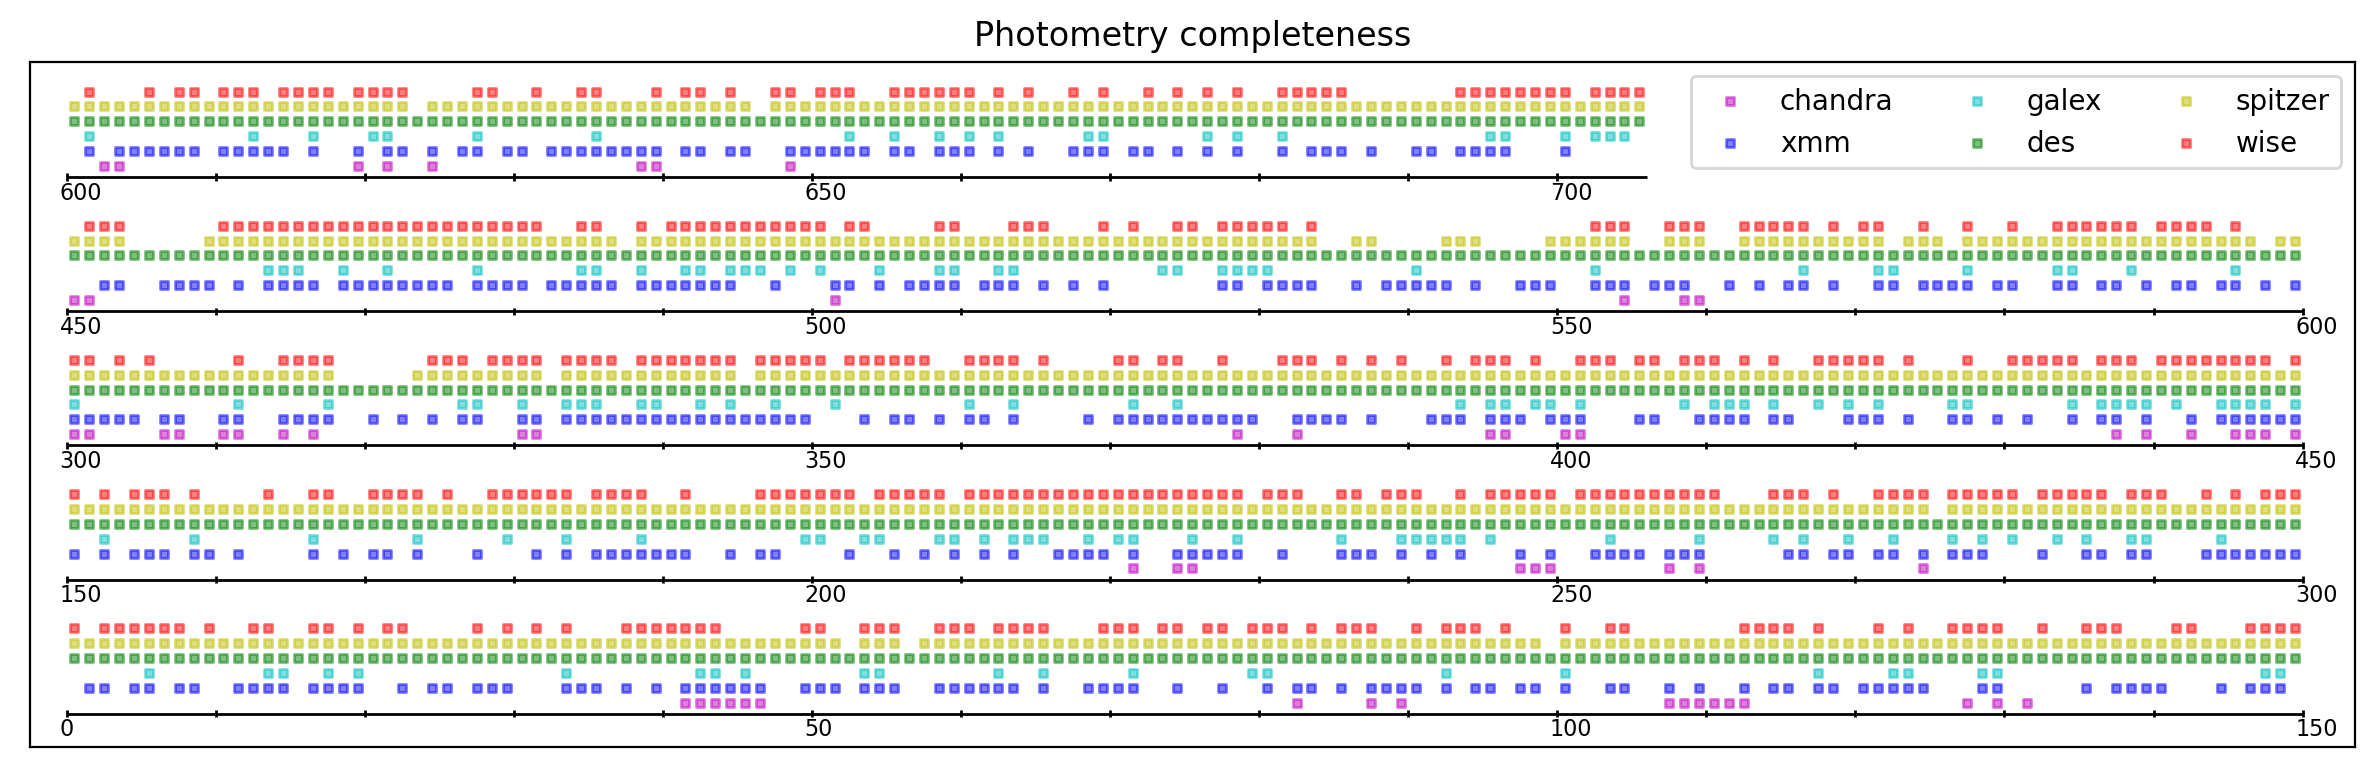

In [17]:
plt.figure(figsize=(15, 5))

cmap='krygcbm'[::-1]
maxrow = 9
maxcol = 150
    
for j in range(5):
    comp_sub = comp[maxcol*j:min(maxcol*(j+1),len(comp))]
    for i, name in enumerate(comp_sub.colnames[1:]):
        has_value = comp_sub['id'][comp_sub[name]] - maxcol*j
        plt.scatter(has_value, [i+maxrow*j]*len(has_value), 
                    label=name, marker='s', c=cmap[i], alpha=0.5, s=10)
    if len(comp_sub)>=0: plt.text(0, maxrow*j-1, 0+maxcol*j, size=8, ha='left', va='top')
    if len(comp_sub)>=50: plt.text(50, maxrow*j-1, 50+maxcol*j, size=8, ha='left', va='top')
    if len(comp_sub)>=100: plt.text(100, maxrow*j-1, 100+maxcol*j, size=8, ha='left', va='top')
    if len(comp_sub)>=150: plt.text(150, maxrow*j-1, 150+maxcol*j, size=8, ha='left', va='top')
    plt.hlines(maxrow*j-0.75, 0.5, len(comp_sub)+0.5, color='k', linewidth=1)
    for i in range(0, len(comp_sub)+1, 10): plt.vlines(i+0.5, maxrow*j-1, maxrow*j-0.5, color='k', linewidth=1)
    if j==0: plt.legend(frameon=True, ncol=3, loc='upper right', prop={'size': 10})

ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect('equal')
ax.set_xlim(-2, 154)
ax.set_ylim(-3, 43)
ax.set_title('Photometry completeness')

plt.show()

In [27]:
data_agn_updated = ascii.read('des_agn_updated.txt')

data_agn_updated[:4]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,1.02,0.03,0.04,nan,None,0.4,nan,SN-C3,-1.0,--,-1.0,-1.0
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,0.24,0.04,0.02,nan,None,18.6,nan,SN-C3,-1.0,--,-1.0,-1.0
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,1.09,0.02,0.02,nan,None,0.9,nan,SN-C3,-1.0,--,-1.0,-1.0
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,1.3,0.1,0.15,nan,None,1.1,nan,SN-C3,-1.0,--,-1.0,-1.0


read data

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

hdul = fits.open('./cigale/des/fagn1/out/results.fits')
results_fagn1 = hdul[1].data

hdul = fits.open('./cigale/des/float/out/results.fits')
results_float = hdul[1].data
results = results_float

dM = 0.434*results_float['bayes.stellar.m_star_err']/results_float['bayes.stellar.m_star']
dMtot = np.sqrt(dM**2 + (0.2)**2)

SF_excess = []

z = data_phot['redshift']
    
for i, row in enumerate(results): # Don't change this

    id = row['ID']

    # Make sure to update filename
    print('reading', id, end='\n' if id%50==0 else '\t')
    hdul = fits.open(f'./cigale/des/float/out/{id}_best_model.fits')
    data = hdul[1].data ##
    sed = hdul[1].data

    stellar_att = sed['xray.galaxy'] + sed['stellar.old'] + sed['stellar.young'] + sed['attenuation.stellar.old'] + sed['attenuation.stellar.young'] + sed['nebular.absorption_old'] + sed['nebular.absorption_young']
    dust = (sed['dust.Umin_Umin'] + sed['dust.Umin_Umax'])
    agn = (sed['xray.agn'] + sed['agn.SKIRTOR2016_torus'] + sed['agn.SKIRTOR2016_polar_dust'] + sed['agn.SKIRTOR2016_disk'] + sed['igm'])
    galaxy_float = agn + stellar_att + dust # only continuum, without line component
    
    hdul = fits.open(f"./cigale/des/fagn1/out/{id}_best_model.fits")
    data_fagn1 = hdul[1].data
    sed = hdul[1].data ##

    stellar_att = sed['xray.galaxy'] + sed['stellar.old'] + sed['stellar.young'] + sed['attenuation.stellar.old'] + sed['attenuation.stellar.young'] + sed['nebular.absorption_old'] + sed['nebular.absorption_young']
    dust = (sed['dust.Umin_Umin'] + sed['dust.Umin_Umax'])
    agn = (sed['xray.agn'] + sed['agn.SKIRTOR2016_torus'] + sed['agn.SKIRTOR2016_polar_dust'] + sed['agn.SKIRTOR2016_disk'] + sed['igm'])
    total_fagn1 = agn + stellar_att + dust # only continuum, without line component

    wave_RF = sed['wavelength']*1e-3/(1 + z[i])
    mask = (wave_RF > 1.1) & (wave_RF < 1.3)
    SF_excess.append(np.mean((galaxy_float/total_fagn1)[mask]))
    #SF_excess.append(np.mean((data['Fnu']/data_fagn1['Fnu'])[mask]))
    
SF_excess = np.array(SF_excess)


fit photometric precision??

360 706


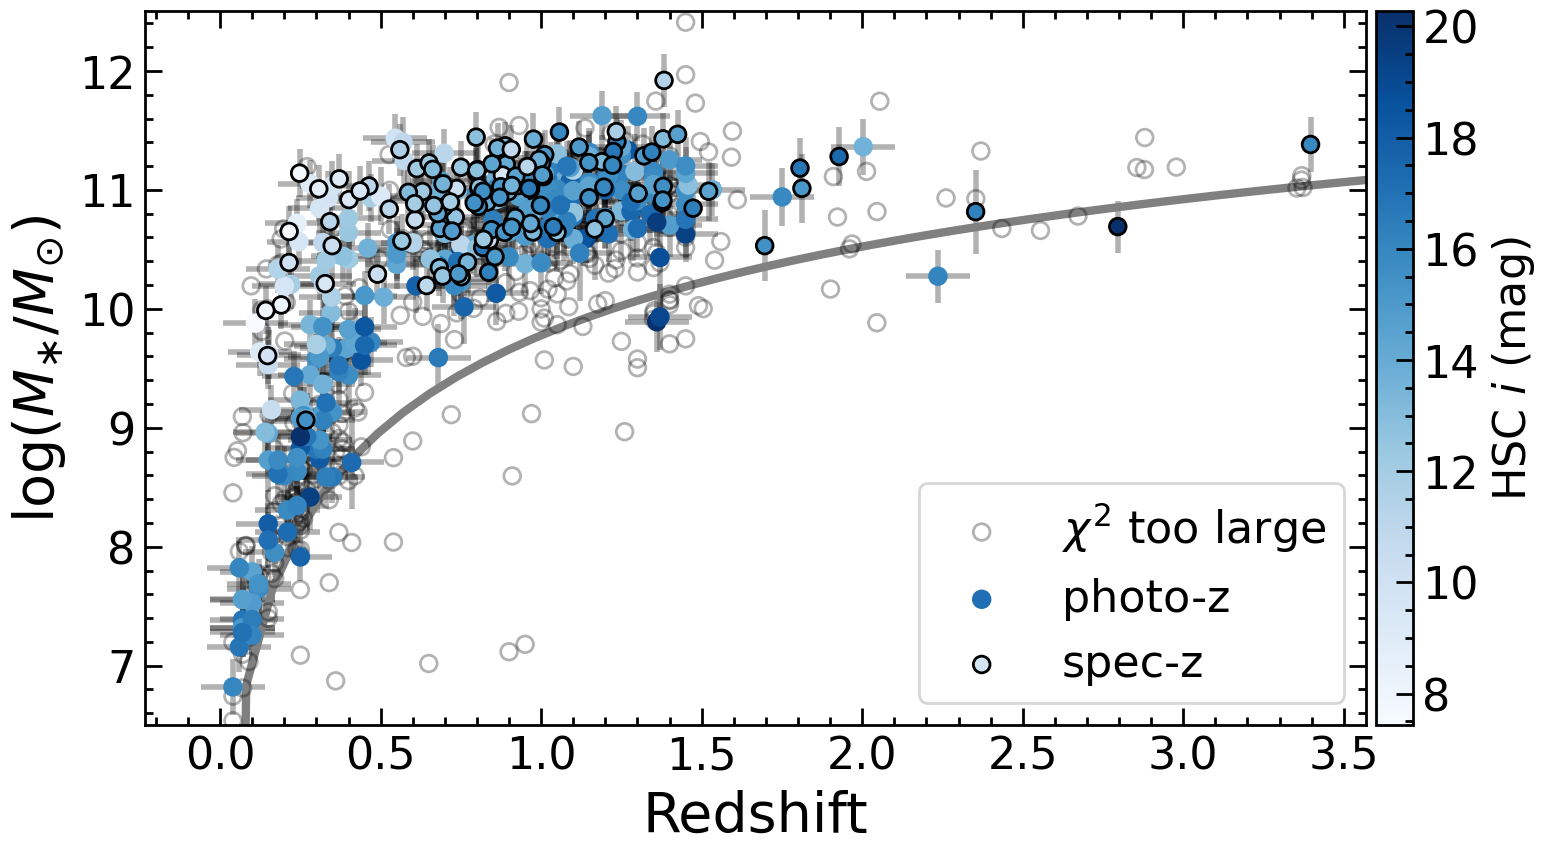

In [148]:

mask_chi2 = (SF_excess > 1.2) & (results_float['best.reduced_chi_square'] < 5)

fig, ax = plt.subplots(1,1, figsize=(8, 4.5))

ax.scatter(z[~mask_chi2], np.log10(results_float['bayes.stellar.m_star'][~mask_chi2]),
            edgecolors='k', c='none', marker='o', alpha=0.3, label=r'$\chi^2$ too large')

imag = -2.5*np.log(data_phot['ctio.decam.i']/3.631)

mask_spec = data_agn['z_best'] > 0

ax.scatter(z[mask_chi2 & ~mask_spec], np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & ~mask_spec]),
                c=imag[mask_chi2 & ~mask_spec],
                marker='o', label='photo-z', cmap='Blues')

im = ax.scatter(z[mask_chi2 & mask_spec], np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & mask_spec]),
                c=imag[mask_chi2 & mask_spec],
                marker='o', edgecolors='k', label='spec-z', cmap='Blues')

ax.errorbar(z[mask_chi2 & mask_spec], np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & mask_spec]), yerr=dMtot[mask_chi2 & mask_spec], marker=None, linestyle='none', color='k', zorder=-1, alpha=0.3)

ax.errorbar(z[mask_chi2 & ~mask_spec], np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & ~mask_spec]), yerr=dMtot[mask_chi2 & ~mask_spec], xerr=0.1, marker=None, linestyle='none', color='k', zorder=-1, alpha=0.3)

print(len(z[mask_chi2]), len(z))

ax.legend(loc=4, frameon=True)
ax.set_xlabel('Redshift', fontsize=20)
ax.set_ylabel(r'$\log(M_{\ast} / M_{\odot})$', fontsize=20)

# ax.set_ylim(7.9, 12)
ax.set_ylim(6.5, 12.5)


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im, cax=cax, cmap='Blues')
cax.set_ylabel(r'HSC $i$ (mag)')

a = -4.7
b = -1.9
m5 = 25.5
gamma = 0.039
SFinf = 0.1
zs = np.linspace(1e-6, 4)
d_pc = cosmo.luminosity_distance(zs).to(u.pc).value
alpha = 0.0 # for galaxies
K = -2.5*(1 + alpha) * np.log10(1 + zs) # K-correction
logM = 1/b*(2.5 * np.log10(SFinf * gamma**-1/2) - a - 5 * np.log10(d_pc) + 5 - K + m5 ) + 3

# BHs are much bigger compared to their hosts, so should outshine host more easily

ax.set_autoscale_on(False)
ax.plot(zs, logM, lw=3, color='gray', zorder=-1)

fig.tight_layout()
fig.savefig('massredshift.pdf', dpi=300)

plt.show()

fagn vs stellar mass??

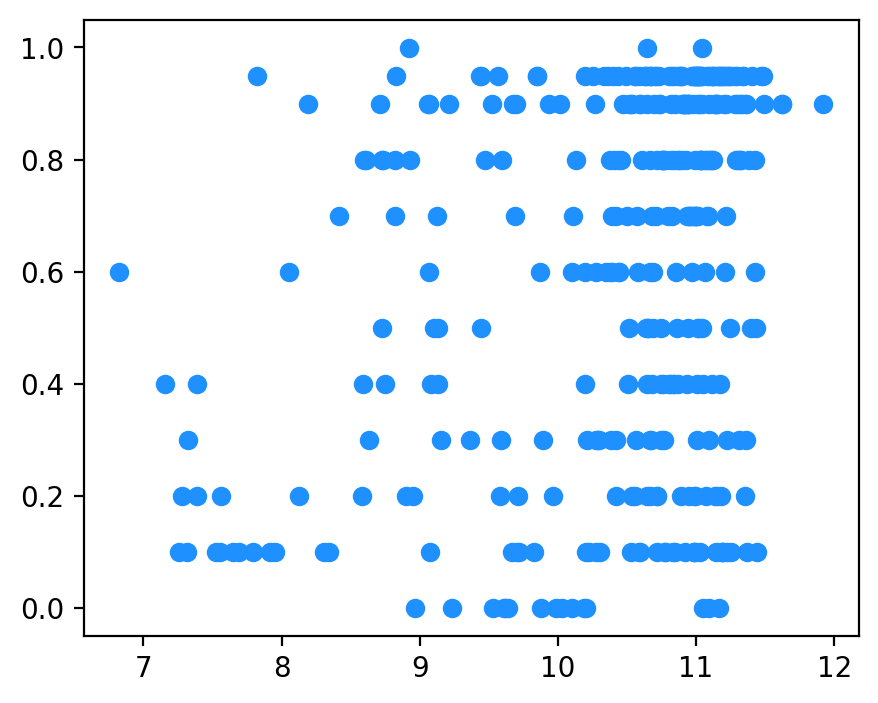

In [89]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

fagn = results_float['best.agn.fracAGN'] #+ np.random.uniform(-0.1, 0.1, size=len(results_float))

ax.scatter(np.log10(results_float['bayes.stellar.m_star'][mask_chi2]), fagn[mask_chi2], 
           label='spec', color='dodgerblue')
#ax.scatter(np.log10(results_float['bayes.stellar.m_star'][~mask_chi2]), fagn[~mask_chi2],
#           label='spec', color='orange')

specz completeness vs stellar mass

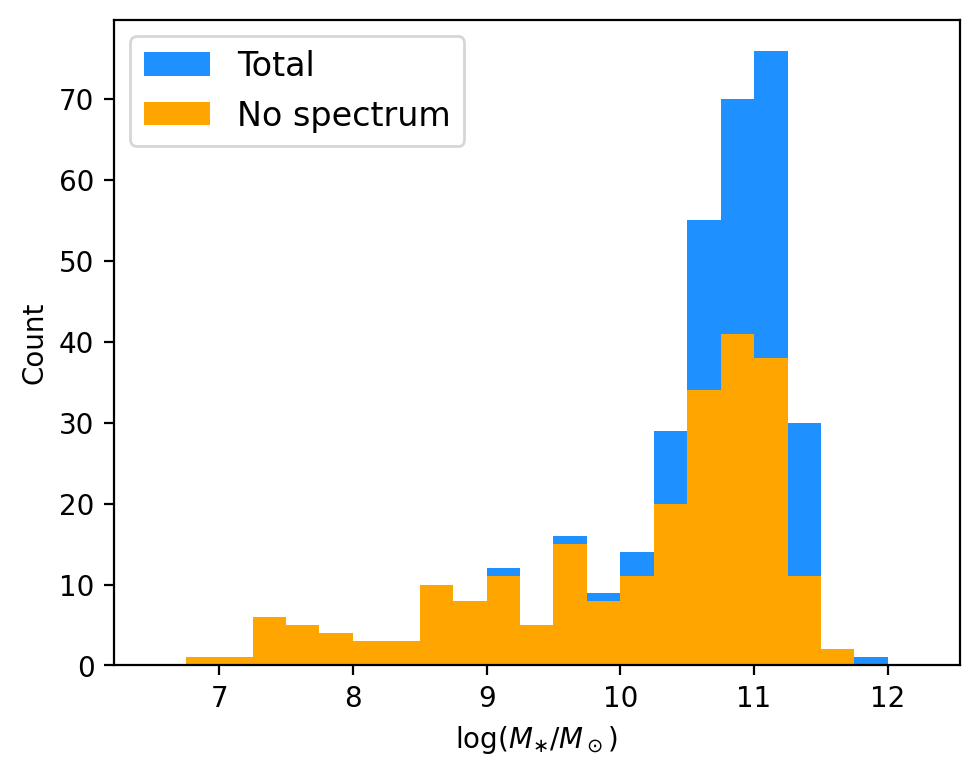

In [112]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

# We are throwing out the very host dominated ones


# Histogram of spec-z vs. photo-z
ax.hist(np.log10(results_float['bayes.stellar.m_star'][mask_chi2]), label='Total', color='dodgerblue', bins=np.arange(6.5, 12.5, 0.25))
ax.hist(np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & ~mask_spec]), label='No spectrum', color='orange', bins=np.arange(6.5, 12.5, 0.25))

# K-S test -- are these drawn from the same distribution



ax.legend(fontsize=12)

ax.set_ylabel('Count')
ax.set_xlabel(r'$\log (M_{\ast} / M_\odot)$')

fig.tight_layout()
fig.savefig('targetingcompleteness.pdf', dpi=300)

No cosmos-webb comparison

outliers

In [131]:
# Outliers is 1e7 not 1e10??
mask = results_float['bayes.stellar.m_star'][mask_chi2] < 1e7
results_float[mask_chi2][mask]['id']

array([381])

In [132]:
results_float['best.reduced_chi_square'][381-1]

3.5291340360806016

In [133]:
data_agn[381-1]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64
J003427.36-434717.13,8.614,-43.7881,22.3,11.4,8.4,$6.6 \pm 0.5$,0.3,$2.4 \pm 0.5$,0.04,0.02,0.01,nan,None,nan,nan,SN-E2,-1.0,--,-1.0,-1.0


In [129]:
data_phot[381-1]

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err,xmm.newton.0p2to0p5,xmm.newton.0p2to0p5_err,xmm.newton.0p5to1,xmm.newton.0p5to1_err,xmm.newton.1to2,xmm.newton.1to2_err,xmm.newton.2to4p5,xmm.newton.2to4p5_err,xmm.newton.4p5to12,xmm.newton.4p5to12_err,xmm.newton.0p2to12,xmm.newton.0p2to12_err,xmm.newton.0p5to4p5,xmm.newton.0p5to4p5_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,ctio.decam.u,ctio.decam.u_err,ctio.decam.g,ctio.decam.g_err,ctio.decam.r,ctio.decam.r_err,ctio.decam.i,ctio.decam.i_err,ctio.decam.z,ctio.decam.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,WISE1,WISE1_err,WISE2,WISE2_err,WISE3,WISE3_err,WISE4,WISE4_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
381,0.04,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0038958225264617663,2.9139209929940117e-05,0.004560875273320777,1.7368183557752982e-05,0.004470114836632666,2.2739226109033366e-05,0.005023831648600073,3.461079861511215e-05,0.00599317730267794,6.0434216512112287e-05,0.005775674000696026,0.00014717482233005596,0.008565394805802134,0.00011860320339562933,0.010934148638103906,0.00010429266699402743,0.010008,0.000444,0.013872,0.000671,-9999.0,-9999.0,0.020944,0.00609,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


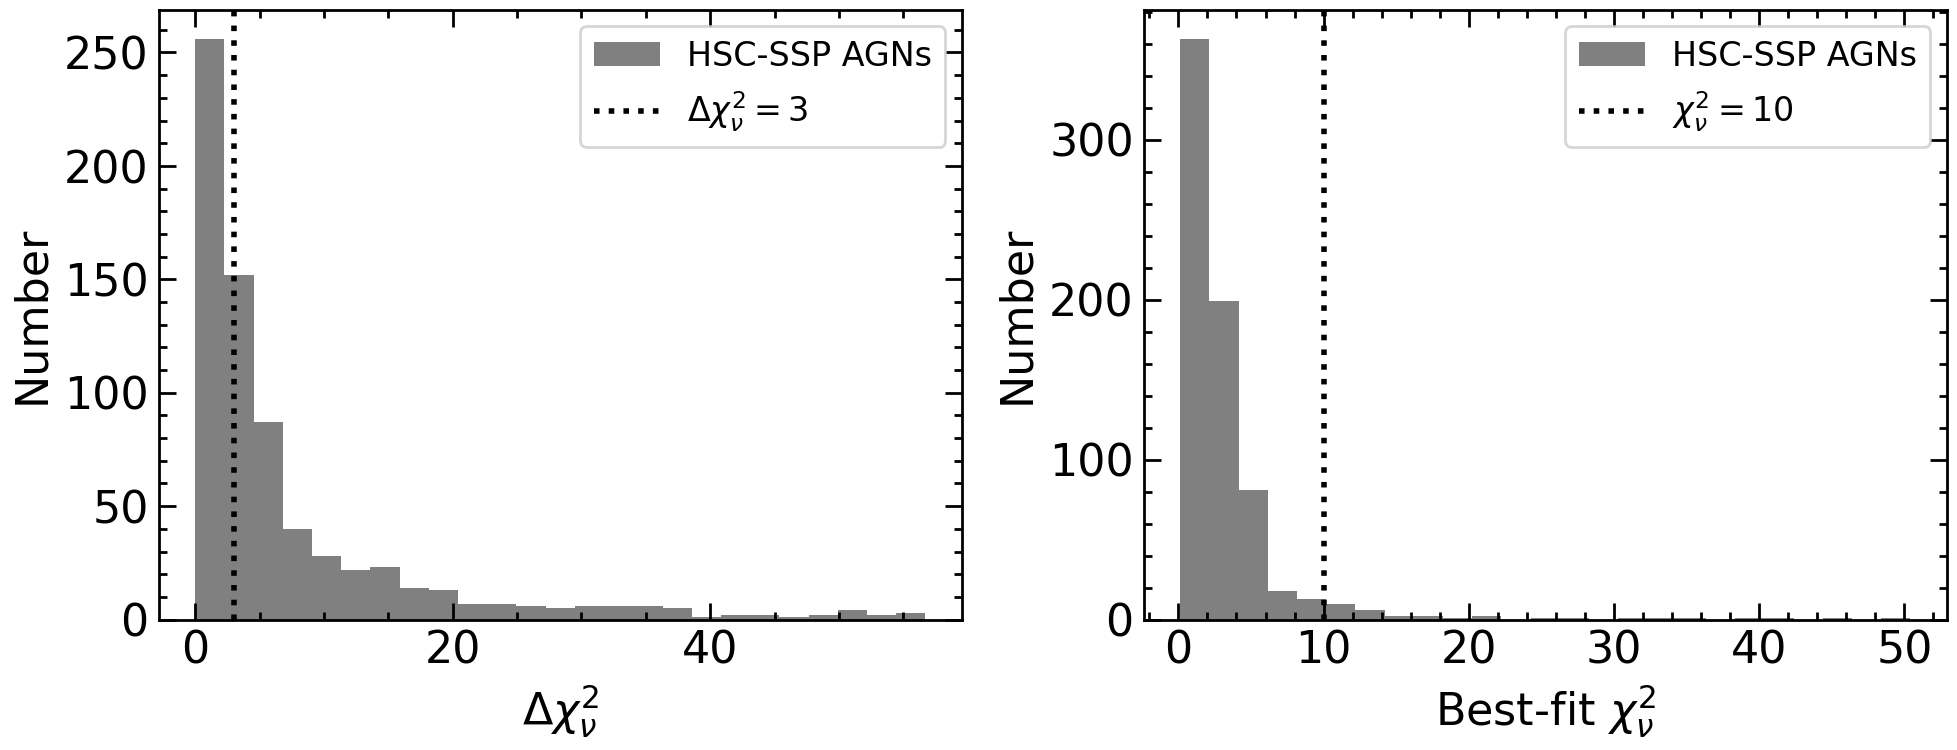

In [149]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))

ax = axs[0]
ax.hist((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']), bins=25, color='gray', label='HSC-SSP AGNs')
ax.axvline(3,0,1,c='k', linestyle='dotted', label=r'$\Delta \chi_\nu^2 = 3$')
ax.legend(fontsize=12, frameon=True)
ax.set_xlabel(r'$\Delta \chi_\nu^2$')
ax.set_ylabel(r'Number')

ax = axs[1]
ax.hist(results_float['best.reduced_chi_square'], bins=25, color='gray', label='HSC-SSP AGNs')
ax.axvline(10,0,1,c='k', linestyle='dotted', label=r'$\chi_\nu^2 = 10$')
ax.legend(fontsize=12, frameon=True)
ax.set_xlabel(r'Best-fit $\chi_\nu^2$')
ax.set_ylabel(r'Number')

fig.tight_layout()
fig.savefig('chi2dist.pdf', dpi=300)

# TESTING CODE

### Get Newton XMM-OM UV data

In [594]:
properties = ['', 'e_']
bands = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V']
columns = ['RAJ2000', 'DEJ2000'] + [p + b + 'mAB' for b, p in product(bands, properties)]
for c in columns: print(c, end=', ')

result = Vizier(columns=columns).query_region(cat_agn, width="3s", catalog=["II/378"])
data_xmm_om = result[0]
data_xmm_om

RAJ2000, DEJ2000, UVW2mAB, e_UVW2mAB, UVM2mAB, e_UVM2mAB, UVW1mAB, e_UVW1mAB, UmAB, e_UmAB, BmAB, e_BmAB, VmAB, e_VmAB, 

_q,RAJ2000,DEJ2000,UVW2mAB,e_UVW2mAB,UVM2mAB,e_UVM2mAB,UVW1mAB,e_UVW1mAB,UmAB,e_UmAB,BmAB,e_BmAB,VmAB,e_VmAB
,deg,deg,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int32,float64,float64,float64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64
4,52.189318,-27.188028,--,--,--,--,21.5185,0.153913,--,--,--,--,--,--
6,52.209301,-27.202059,19.73849,0.118531,19.3634,0.060929,19.4586,0.048468,--,--,--,--,--,--
14,52.606074,-27.472653,20.19275,0.129924,20.2752,0.099778,20.4231,0.103274,--,--,--,--,--,--
15,52.655272,-27.485078,21.52318,0.379260,20.9081,0.150123,20.7170,0.086877,--,--,--,--,--,--
17,52.158369,-27.312077,--,--,21.4724,0.229559,21.1248,0.119401,--,--,--,--,--,--
18,52.037133,-27.355643,--,--,20.5898,0.120933,20.3316,0.095978,--,--,--,--,--,--
18,52.037397,-27.355463,--,--,20.9382,0.224992,20.6169,0.121118,--,--,--,--,--,--
20,52.214870,-27.414776,--,--,--,--,21.4881,0.161763,--,--,--,--,--,--


Install filters

In [586]:
%%script true

# generate filter files
xmm_om_filers = ascii.read('OM_response_081008.txt', header_start=3)
for band in ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V']:
    filter = xmm_om_filers[['nm', band]]
    filter['nm']*=10 # nm to Angstrom
    filter.meta['comments'] = [f'xmm.om.{band}', 'energy', 'xmm-om filter downloaded from https://sasdev-xmm.esac.esa.int/pub/ccf/constituents/extras/responses/OM/OM_response_081008.txt']
    filter.write(f'cigale/xmm.om.{band}.dat', format='ascii.no_header', overwrite=True)

# install filters
for band in ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V']:
    os.system(f'pcigale-filters add cigale/xmm.om.{band}.dat')

Importing xmm.om.UVW2... (601 points)
Importing xmm.om.UVM2... (601 points)
Importing xmm.om.UVW1... (601 points)
Importing xmm.om.U... (601 points)
Importing xmm.om.B... (601 points)
Importing xmm.om.V... (601 points)


Add queried data to our table

In [ ]:
def abmag_to_mjy(mag, magerr):
    mag = mag * u.ABmag
    magerr = magerr*u.ABmag
    flux = mag.to(u.mJy, equivalencies=u.spectral_density(3631*u.Jy))
    b_flux = (mag+magerr).to(u.mJy, equivalencies=u.spectral_density(3631*u.Jy))
    B_flux = (mag+magerr).to(u.mJy, equivalencies=u.spectral_density(3631*u.Jy))
    fluxerr = (B_flux - b_flux)/2
    return flux.value, fluxerr.value

# properties = ['', 'e_']
# bands = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V']
# columns = [p + b + 'mAB' for b, p in product(bands, properties)]

# result = Vizier(columns=columns).query_region(cat_agn, width="3s", catalog=["II/378"])
# result[0]

abmag_to_mjy(20.4138)

In [564]:
def abmag_to_mjy(ab_mag,):
    ab_mag_quantity = ab_mag * u.ABmag
    flux_density_mjy = ab_mag_quantity.to(u.mJy, equivalencies=u.spectral_density(3631*u.Jy))
    return flux_density_mjy.value


abmag_to_mjy(20.4138)

0.024801617193949372

In [568]:
(u.erg/u.cm/u.cm/u.Hz/u.s*1.36E-27).to(u.mJy)

<Quantity 0.136 mJy>

Install filters

Data availibility: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=XMM/OM.V_filter&&mode=browse&gname=XMM&gname2=OM ??

In [588]:
data_xmm_om

NameError: name 'data_xmm_om' is not defined

In [ ]:
# %%script true # skip this cell when running all if these filters are already generated

# generate and install filters
boxcars = [[0.5, 7], [2, 7], [1.2, 2], [0.5, 1.2], [0.2, 0.5], [0.1, 10]]
for lw, hw in boxcars:
    l = str(lw).replace('.', 'p')
    h = str(hw).replace('.', 'p')
    xray_filter.write_boxcar_filter(f'cigale/xmm.newton.{l}to{h}.dat', f'xmm.{l}to{h}', lw, hw)
    os.system(f'pcigale-filters add cigale/xmm.newton.{l}to{h}.dat')